
=== RESULTS — YoY Slope (Δ count) for CE and CEM ===
 Year CE_slope CEM_slope
 2020       NA        NA
 2021       +6         0
 2022       +5        +4
 2023      +23        +4
 2024      +45        +5
 2025      +38        +5


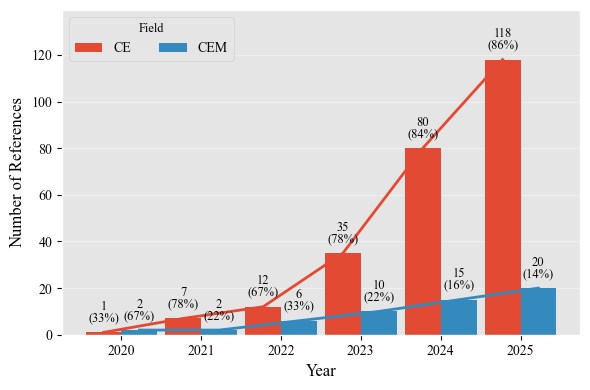

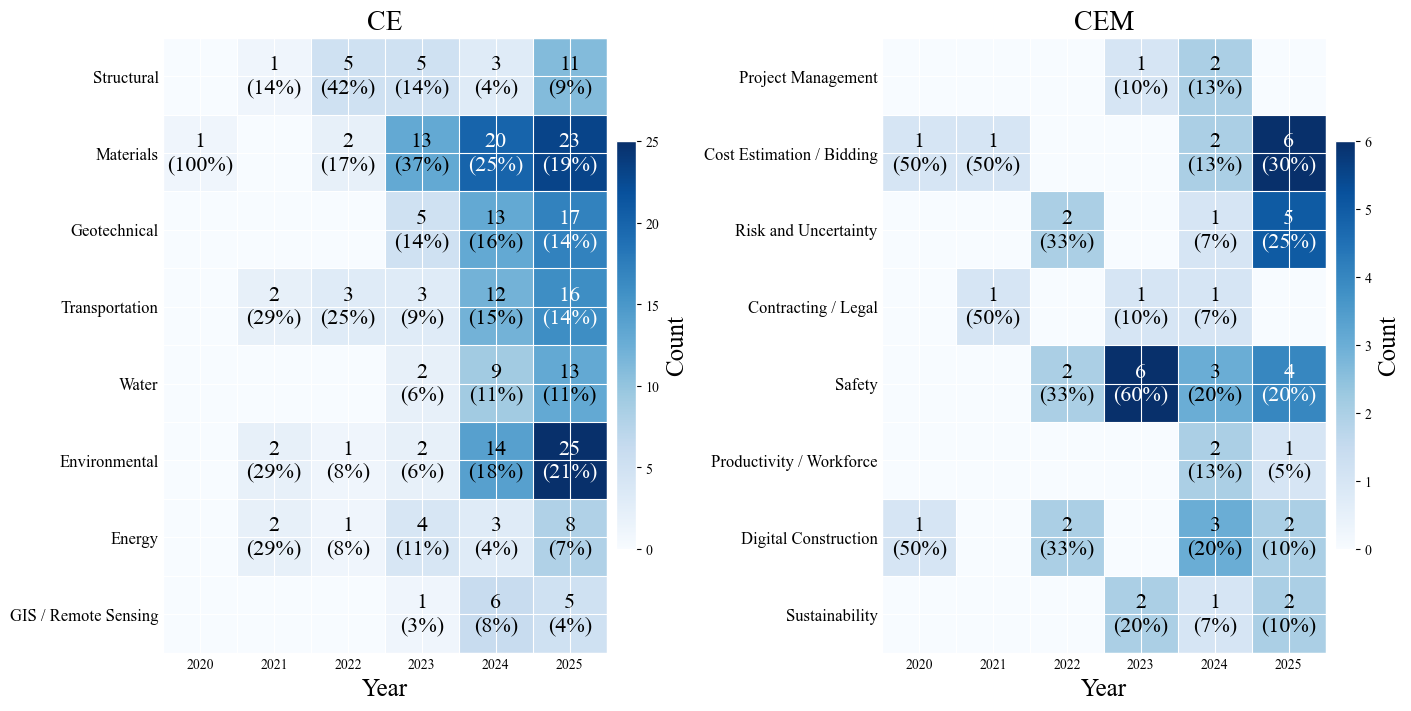

In [2]:
# ==== CE/CEM COUNTS + COMPOSITION HEATMAPS (two figures; 2-line bar labels) ====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ---------- helpers ----------
def pick_col(cols, candidates):
    lc = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in lc:
            return lc[cand.lower()]
    return None

def normalize_spaces(s: str) -> str:
    s = re.sub(r"\s+", " ", s.strip())
    s = re.sub(r"\s*/\s*", " / ", s)          # tidy slashes
    s = re.sub(r"\s*&\s*", " & ", s)          # tidy ampersands
    s = s.replace(" and ", " & ")             # unify "and" to "&"
    return s

# ---------- 1) Load ----------
df = pd.read_csv("xai_references_labeled.csv")

# detect columns
year_col = pick_col(df.columns, ["year","Year","pub_year"])
field_col = pick_col(df.columns, ["field","Field","Field_Category","discipline"])
subc_col  = pick_col(df.columns, ["subcategory","Sub_Category","sub_category","Subcategory"])
if not (year_col and field_col and subc_col):
    raise ValueError(f"Need year/field/subcategory columns; found: {list(df.columns)}")

df = df.rename(columns={year_col:"Year", field_col:"Field", subc_col:"Subcat"}).copy()

# ---------- 2) Clean + map field to CE/CEM ----------
df["Year"]  = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df["Field"] = df["Field"].astype(str).str.strip().str.lower()
df["Subcat"]= df["Subcat"].astype(str).map(lambda s: normalize_spaces(s))

field_map = {
    "civil engineering": "CE", "ce": "CE",
    "construction engineering & management": "CEM",
    "construction engineering and management": "CEM",
    "cem": "CEM",
}
df["Field"] = df["Field"].map(lambda s: field_map.get(s, s.upper()))

df = df.dropna(subset=["Year","Field","Subcat"])
df = df[(df["Year"]>=2020) & (df["Year"]<=2025)]
df = df[df["Field"].isin(["CE","CEM"])]

# ---------- 3) Canonical subcategory sets (order preserved) ----------
CE_SUBS  = [
    "Structural","Materials","Geotechnical","Transportation",
    "Water","Environmental","Energy","GIS / Remote Sensing"
]
# NOTE: "Equipment / Operations" intentionally removed from CEM
CEM_SUBS = [
    "Project Management","Cost Estimation / Bidding","Risk and Uncertainty",
    "Contracting / Legal","Safety",
    "Productivity / Workforce",
    "Digital Construction (BIM, AI, Sensors, Robotics)",
    "Sustainability (Construction)"
]

# synonyms → canonical
synonyms = {
    # CE
    "structural": "Structural",
    "materials": "Materials",
    "geotechnical": "Geotechnical",
    "transportation": "Transportation",
    "water": "Water",
    "environmental": "Environmental",
    "energy": "Energy",
    "gis/remote sensing": "GIS / Remote Sensing",
    # CEM
    "project management": "Project Management",
    "cost estimation / bidding": "Cost Estimation / Bidding",
    "cost estimation/bidding": "Cost Estimation / Bidding",
    "risk & uncertainty": "Risk and Uncertainty",
    "risk and uncertainty": "Risk and Uncertainty",
    "contracting / legal": "Contracting / Legal",
    "contracting/legal": "Contracting / Legal",
    "safety": "Safety",
    "productivity / workforce": "Productivity / Workforce",
    "digital construction (bim, ai, sensors, robotics)": "Digital Construction (BIM, AI, Sensors, Robotics)",
    "sustainability (construction)": "Sustainability (Construction)",
}
def canonical_subcat(s: str) -> str:
    key = normalize_spaces(s).lower()
    return synonyms.get(key, s)

df["Subcat"] = df["Subcat"].map(canonical_subcat)

# ---------- 4) Validate: keep only the correct subcategories per field ----------
def filter_by_field(d: pd.DataFrame, field: str) -> pd.DataFrame:
    allowed = CE_SUBS if field=="CE" else CEM_SUBS
    unexpected = sorted(set(d.loc[d["Field"]==field, "Subcat"]) - set(allowed))
    if unexpected:
        print(f"[WARN] {field}: {len(unexpected)} unexpected subcategory name(s) not in your list.")
        print("       Examples:", unexpected[:10])
    return d[(d["Field"]==field) & (d["Subcat"].isin(allowed))].copy()

df_ce  = filter_by_field(df, "CE")
df_cem = filter_by_field(df, "CEM")

years  = sorted(df["Year"].unique().tolist())

# ---------- 5) Bar chart data (counts per year by field) ----------
counts_year_field = (
    df.groupby(["Year","Field"]).size().unstack("Field", fill_value=0)
      .reindex(index=years, columns=["CE","CEM"], fill_value=0)
)
# percentages within each YEAR (rowwise) so CE% + CEM% = 100
year_totals = counts_year_field.sum(axis=1).replace(0, np.nan)
perc_year_field = counts_year_field.div(year_totals, axis=0) * 100.0

# ---------- 5.1) RESULTS TABLE: YoY SLOPE (Δ count) for CE and CEM ----------
years_full = list(range(2020, 2026))
counts_full = counts_year_field.reindex(years_full, fill_value=0)
slopes = counts_full.diff(axis=0)

def fmt_slope(x):
    if pd.isna(x):
        return "NA"
    x = int(x)
    return f"+{x}" if x > 0 else str(x)

results_slope = (
    slopes.rename(columns={"CE":"CE_slope","CEM":"CEM_slope"})
          .reset_index(names="Year")
)
for col in ["CE_slope","CEM_slope"]:
    results_slope[col] = results_slope[col].map(fmt_slope)

print("\n=== RESULTS — YoY Slope (Δ count) for CE and CEM ===")
print(results_slope.to_string(index=False))

# ---------- 6) Heatmap matrices (counts + % within year) ----------
def matrices(d: pd.DataFrame, sub_order: list, years_list: list):
    cnt = d.groupby(["Subcat","Year"]).size().unstack("Year", fill_value=0)
    cnt = cnt.reindex(index=sub_order, columns=years_list, fill_value=0)
    col_sums = cnt.sum(axis=0).replace(0, np.nan)
    pct = cnt.divide(col_sums, axis=1) * 100.0
    return cnt, pct

cnt_CE,  pct_CE  = matrices(df_ce,  CE_SUBS, years)
cnt_CEM, pct_CEM = matrices(df_cem, CEM_SUBS, years)

# ---------- 7) STYLE ----------
plt.style.use("ggplot")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({
    "text.color":"black","axes.labelcolor":"black",
    "xtick.color":"black","ytick.color":"black",
})

# ============================================================
# FIGURE 1: Grouped bar chart (6 x 4) with two-line annotations + YoY lines
# ============================================================
fig1, ax_bar = plt.subplots(figsize=(6, 4))

x = np.arange(len(years))
w = 0.45

bars_ce  = ax_bar.bar(x - w/2, counts_year_field["CE"].values,  width=w, label="CE")
bars_cem = ax_bar.bar(x + w/2, counts_year_field["CEM"].values, width=w, label="CEM")

ax_bar.set_xticks(x)
ax_bar.set_xticklabels([str(y) for y in years])
ax_bar.set_ylabel("Number of References")
ax_bar.set_xlabel("Year")

ax_bar.legend(title="Field", ncols=2, loc="upper left", fontsize=10, title_fontsize=9)
ax_bar.grid(axis="y", linestyle="-", linewidth=0.6, alpha=0.5)
ax_bar.grid(axis="x", visible=False)

max_bar = max(counts_year_field.to_numpy().ravel().max(), 1)
ax_bar.set_ylim(0, max_bar * 1.18)

def annotate_group(ax, bars, perc_series):
    for rect, pct in zip(bars, perc_series.values):
        h = rect.get_height()
        pct_str = "0%" if pd.isna(pct) else f"{pct:.0f}%"
        ax.text(
            rect.get_x() + rect.get_width()/2,
            h + max_bar*0.03,
            f"{int(h)}\n({pct_str})",
            ha="center", va="bottom", fontsize=9, linespacing=0.9,
            zorder=5  # <-- keep labels in front of YoY lines
        )

# First draw YoY lines
centers_ce  = np.array([b.get_x() + b.get_width()/2 for b in bars_ce])
tops_ce     = np.array([b.get_height() for b in bars_ce])
ax_bar.plot(centers_ce, tops_ce, linewidth=2, color=bars_ce[0].get_facecolor(), zorder=3)

centers_cem = np.array([b.get_x() + b.get_width()/2 for b in bars_cem])
tops_cem    = np.array([b.get_height() for b in bars_cem])
ax_bar.plot(centers_cem, tops_cem, linewidth=2, color=bars_cem[0].get_facecolor(), zorder=3)

# Then add annotations with higher zorder so they appear on top
annotate_group(ax_bar, bars_ce,  perc_year_field["CE"])
annotate_group(ax_bar, bars_cem, perc_year_field["CEM"])

fig1.tight_layout()
# fig1.savefig("figure1_counts_with_yoy_lines.png", dpi=300)

# ============================================================
# FIGURE 2: Two-panel heatmaps (CE left, CEM right)
#   - Display-only rename for one CEM label
#   - Auto white/black text per cell for contrast
# ============================================================
fig2, (ax_ce, ax_cem) = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

# Display-only rename for CEM y-axis
CEM_DISPLAY_MAP = {
    "Digital Construction (BIM, AI, Sensors, Robotics)": "Digital Construction",
    "Sustainability (Construction)": "Sustainability"
}

def draw_heatmap(ax, cnt, pct, title, display_index=None):
    vmax = max(1, int(np.nanmax(cnt.values)))
    norm = Normalize(vmin=0, vmax=vmax)
    cmap = plt.get_cmap("Blues")

    im = ax.imshow(cnt.values, aspect="auto", cmap=cmap, norm=norm)

    # y labels (optionally remapped for display only)
    ylabels = list(cnt.index)
    if display_index is not None:
        ylabels = [display_index.get(lbl, lbl) for lbl in ylabels]

    ax.set_yticks(np.arange(len(cnt.index)))
    ax.set_yticklabels(ylabels, fontsize=12, rotation=0)
    ax.set_xticks(np.arange(len(cnt.columns)))
    ax.set_xticklabels([str(y) for y in cnt.columns])
    ax.set_xlabel("Year", fontsize=18)
    ax.set_title(title, fontsize=20, pad=6)

    ax.set_xticks(np.arange(-.5, len(cnt.columns), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(cnt.index), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.8)
    ax.tick_params(which="both", length=0)

    # annotate with adaptive text color based on background luminance
    for i in range(cnt.shape[0]):
        for j in range(cnt.shape[1]):
            c = int(cnt.iat[i, j]); p = pct.iat[i, j]
            if c > 0 and pd.notna(p):
                r, g, b, _ = cmap(norm(c))
                luminance = 0.299*r + 0.587*g + 0.114*b
                txt_color = "white" if luminance < 0.5 else "black"
                ax.text(j, i, f"{c}\n({p:.0f}%)",
                        ha="center", va="center", fontsize=16, color=txt_color)

    cbar = fig2.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("Count", rotation=90, fontsize=18)

# CE heatmap (no label changes)
draw_heatmap(ax_ce,  cnt_CE,  pct_CE,  "CE")

# CEM heatmap (apply display-only rename for the long label)
draw_heatmap(ax_cem, cnt_CEM, pct_CEM, "CEM", display_index=CEM_DISPLAY_MAP)

# fig2.savefig("figure2_heatmaps_ce_cem.png", dpi=300)
plt.show()



Top 20 domain words in CE abstracts (after cleaning)
 1. urban — 221
 2. strength — 211
 3. concrete — 205
 4. risk — 159
 5. construction — 156
 6. design — 136
 7. compressive — 117
 8. parameters — 112
 9. environment — 105
10. explanations — 104
11. boosting — 103
12. built — 102
13. flood — 102
14. building — 100
15. gradient — 94
16. management — 93
17. sustainable — 88
18. land — 88
19. spatial — 88
20. inf — 88

Top 20 domain words in CEM abstracts (after cleaning)
 1. construction — 119
 2. risk — 84
 3. safety — 43
 4. project — 39
 5. decision — 39
 6. cost — 35
 7. projects — 33
 8. industry — 32
 9. management — 29
10. workers — 29
11. energy — 28
12. explanations — 27
13. ergonomic — 26
14. bim — 24
15. regression — 23
16. information — 20
17. interpretability — 19
18. solutions — 19
19. real — 19
20. accidents — 19


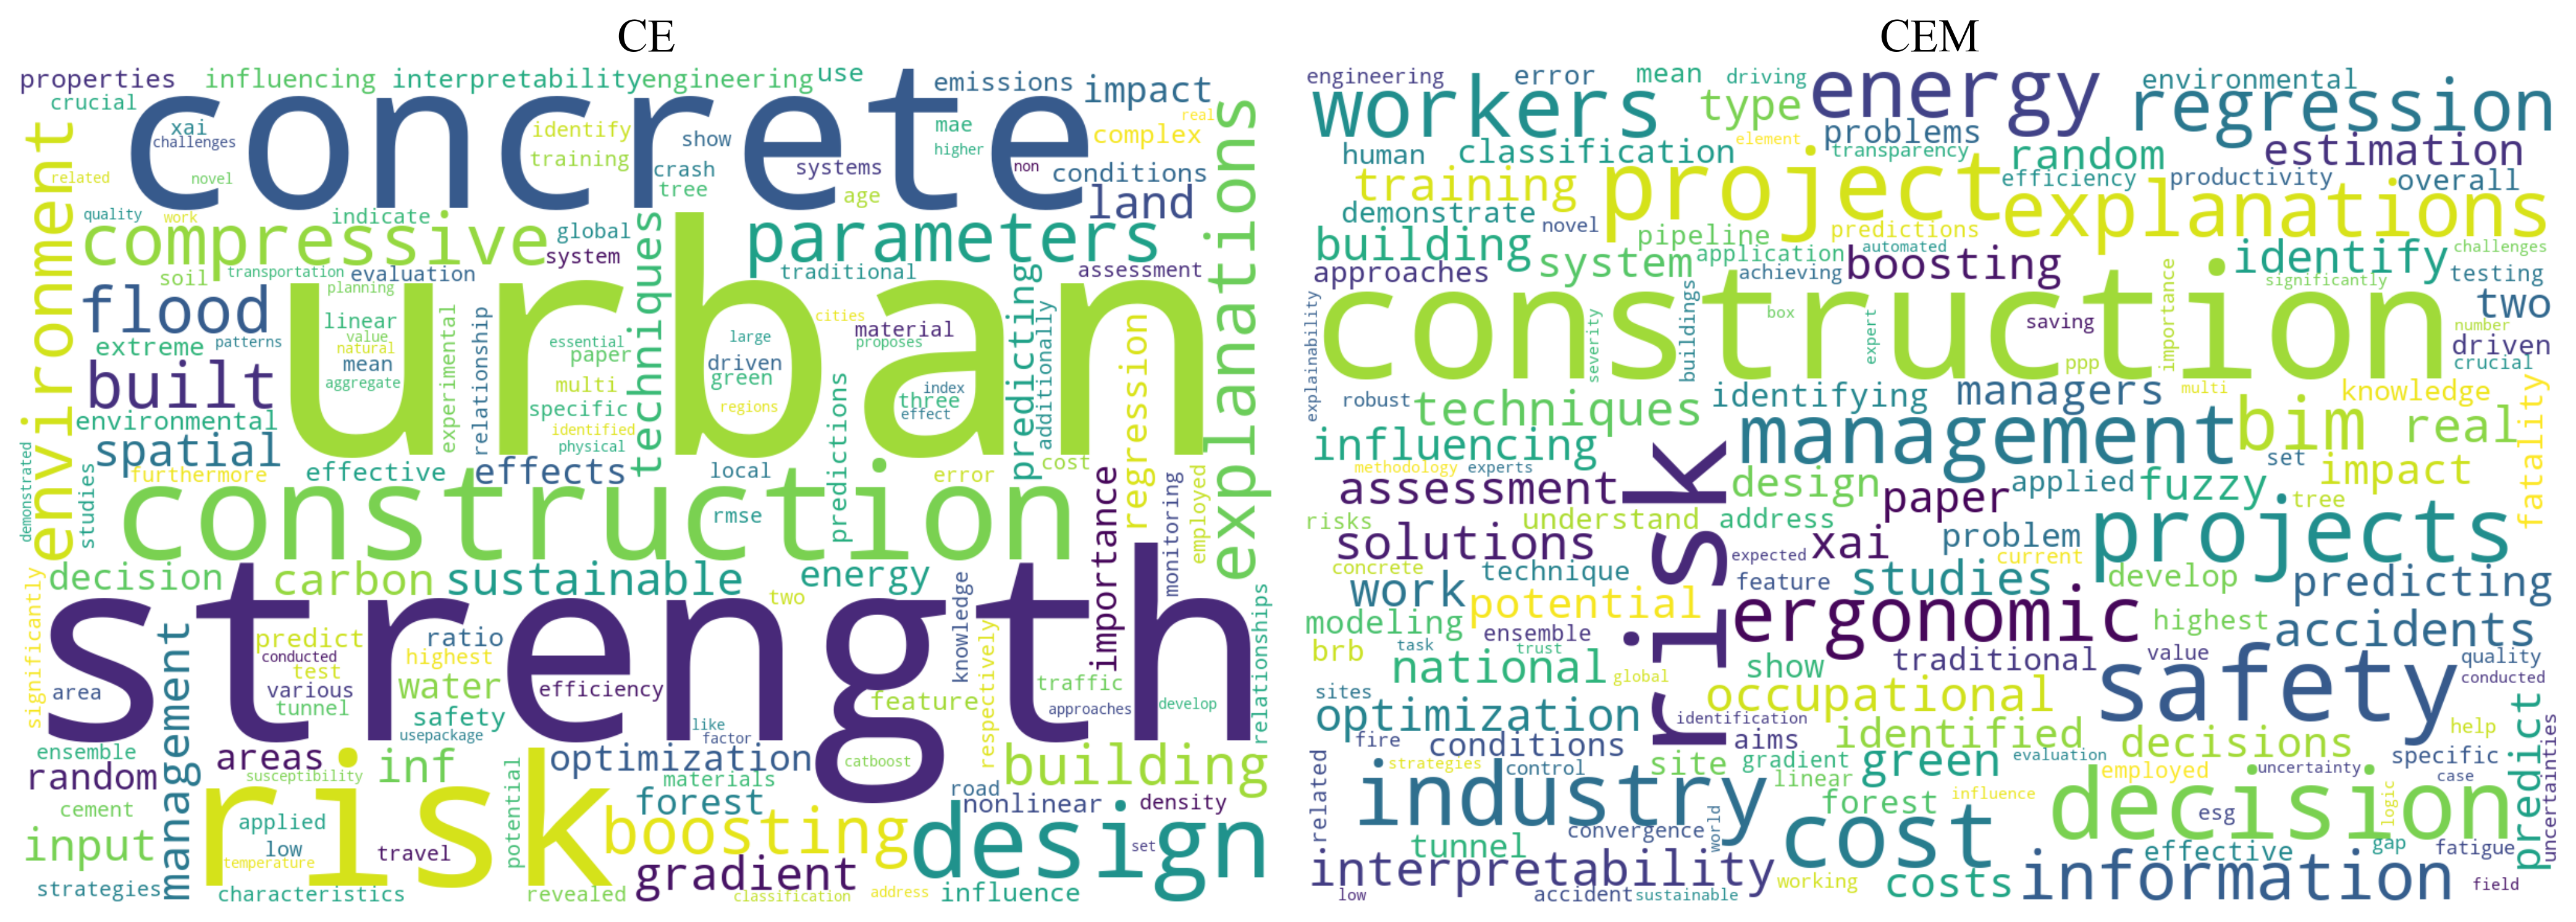

In [1]:
# === CE vs. CEM Themes from Abstracts (clean + visualize, fixed layout, black titles) ===
# Jupyter-ready. Requires: pandas, matplotlib, wordcloud, nltk
# If needed: pip install wordcloud nltk

import re
import collections
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# --- NLTK stopwords (download once) ---
try:
    from nltk.corpus import stopwords
except Exception:
    import nltk
    nltk.download("stopwords")
    from nltk.corpus import stopwords

# -------------------- CONFIG --------------------
CSV_PATH = "xai_references_labeled.csv"
FIELD_COL = "field"
ABSTRACT_COL = "abstract"

TOP_N_PRINT = 20               # how many top words to print per field
MAX_WORDS_CLOUD = 150          # how many words to show in each cloud

# Base English stopwords
STOPWORDS_EN = set(stopwords.words("english"))

# Optimized, domain-specific stopwords
CUSTOM_STOPWORDS = {
    # basic fillers / function words
    "the","and","for","this","with","that","are","was","were","from","all",
    "can","these","which","between","into","their","most","high",

    # boilerplate (copyright, publisher, etc.)
    "elsevier","rights","reserved",

    # generic academic terms
    "study","analysis","research","results","framework","approach","methods",
    "method","proposed","using","used","based","data","dataset","models","model",
    "performance","accuracy","variables","features","factors","findings",

    # generic AI/XAI terms
    "machine","learning","explainable","interpretable","additive","shap",
    "shapley","xgboost","artificial","intelligence","ai","deep","neural",
    "network","networks","algorithm","algorithms","prediction","predictive"
}

# Optional extra discourse stopwords
EXTRA_CONTEXT_STOPWORDS = {
    "significant","different","however","time","making","important","key",
    "existing","include","including","across","due","best","among","critical",
    "new","values","enhance","improve","also","well","provide","provides",
    "compared","level","levels","process","processes","development","developed",
    "insights","comprehensive","accurate","optimal","support","understanding"
}

# Final stopword set
STOPWORDS_ALL = STOPWORDS_EN | CUSTOM_STOPWORDS | EXTRA_CONTEXT_STOPWORDS

# -------------------- HELPERS --------------------
def clean_tokens(text: str):
    """Lowercase, strip non-letters, collapse spaces, remove stopwords; return tokens."""
    if pd.isna(text):
        return []
    text = re.sub(r"[^a-zA-Z\s]", " ", str(text).lower())
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [w for w in text.split() if len(w) > 2 and w not in STOPWORDS_ALL]
    return tokens

def freq_from_df(df: pd.DataFrame, col: str):
    c = collections.Counter()
    for t in df[col]:
        c.update(clean_tokens(t))
    return c

def show_top(counter: collections.Counter, label: str, n: int = 20):
    print(f"\nTop {n} domain words in {label} abstracts (after cleaning)")
    for i, (w, cnt) in enumerate(counter.most_common(n), 1):
        print(f"{i:>2}. {w} — {cnt}")

def draw_wc(ax, freqs: dict, title: str):
    ax.set_title(title, fontsize=18, fontname="Times New Roman", color="black")  # only title black
    ax.axis("off")
    if not freqs:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontname="Times New Roman")
        return
    wc = WordCloud(
        width=1200, height=800, background_color="white",
        collocations=False, max_words=MAX_WORDS_CLOUD,
        prefer_horizontal=0.95, normalize_plurals=True,
        random_state=15,  # fixed color layout
        colormap="viridis"  # consistent colorful palette
    )
    wc.generate_from_frequencies(freqs)
    ax.imshow(wc, interpolation="bilinear")

# -------------------- LOAD & SPLIT --------------------
df = pd.read_csv(CSV_PATH)
field_series = df[FIELD_COL].astype(str).str.strip().str.upper()

df_ce  = df[field_series == "CE"].copy()
df_cem = df[field_series == "CEM"].copy()

# -------------------- COUNT --------------------
freq_ce  = freq_from_df(df_ce, ABSTRACT_COL)
freq_cem = freq_from_df(df_cem, ABSTRACT_COL)

# -------------------- PRINT --------------------
show_top(freq_ce,  "CE",  n=TOP_N_PRINT)
show_top(freq_cem, "CEM", n=TOP_N_PRINT)

# -------------------- PLOT --------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
draw_wc(axes[0], dict(freq_ce),  "CE")
draw_wc(axes[1], dict(freq_cem), "CEM")

# plt.suptitle(
#     "CE and CEM research themes from abstracts (Times New Roman, fixed colors)",
#     y=0.97, fontsize=14, fontname="Times New Roman"
# )
plt.tight_layout()
# plt.savefig("CE_CEM_wordcloud_fixedcolor.tif", dpi=300, bbox_inches="tight")
plt.show()


C:\winapps\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(



Top distinctive terms for CE (vs CEM) — TF-IDF mean difference
       term  mean_CE  mean_CEM  distinctiveness
   strength 0.040504  0.003526         0.036977
      urban 0.035338  0.003006         0.032331
   concrete 0.040872  0.010208         0.030664
compressive 0.025758  0.000000         0.025758
      flood 0.025737  0.000000         0.025737
      built 0.017966  0.001228         0.016738
       land 0.017036  0.002036         0.014999
 parameters 0.021699  0.007248         0.014451
      ratio 0.013990  0.000000         0.013990
     cement 0.013969  0.000000         0.013969
    spatial 0.014869  0.000926         0.013942
 properties 0.015691  0.001894         0.013797
      input 0.016757  0.003297         0.013460
environment 0.017906  0.005269         0.012636
      areas 0.013925  0.001604         0.012321
      crash 0.011462  0.000000         0.011462
     design 0.022854  0.011950         0.010904
    extreme 0.011335  0.000793         0.010542
     carbon 0.016345  0.

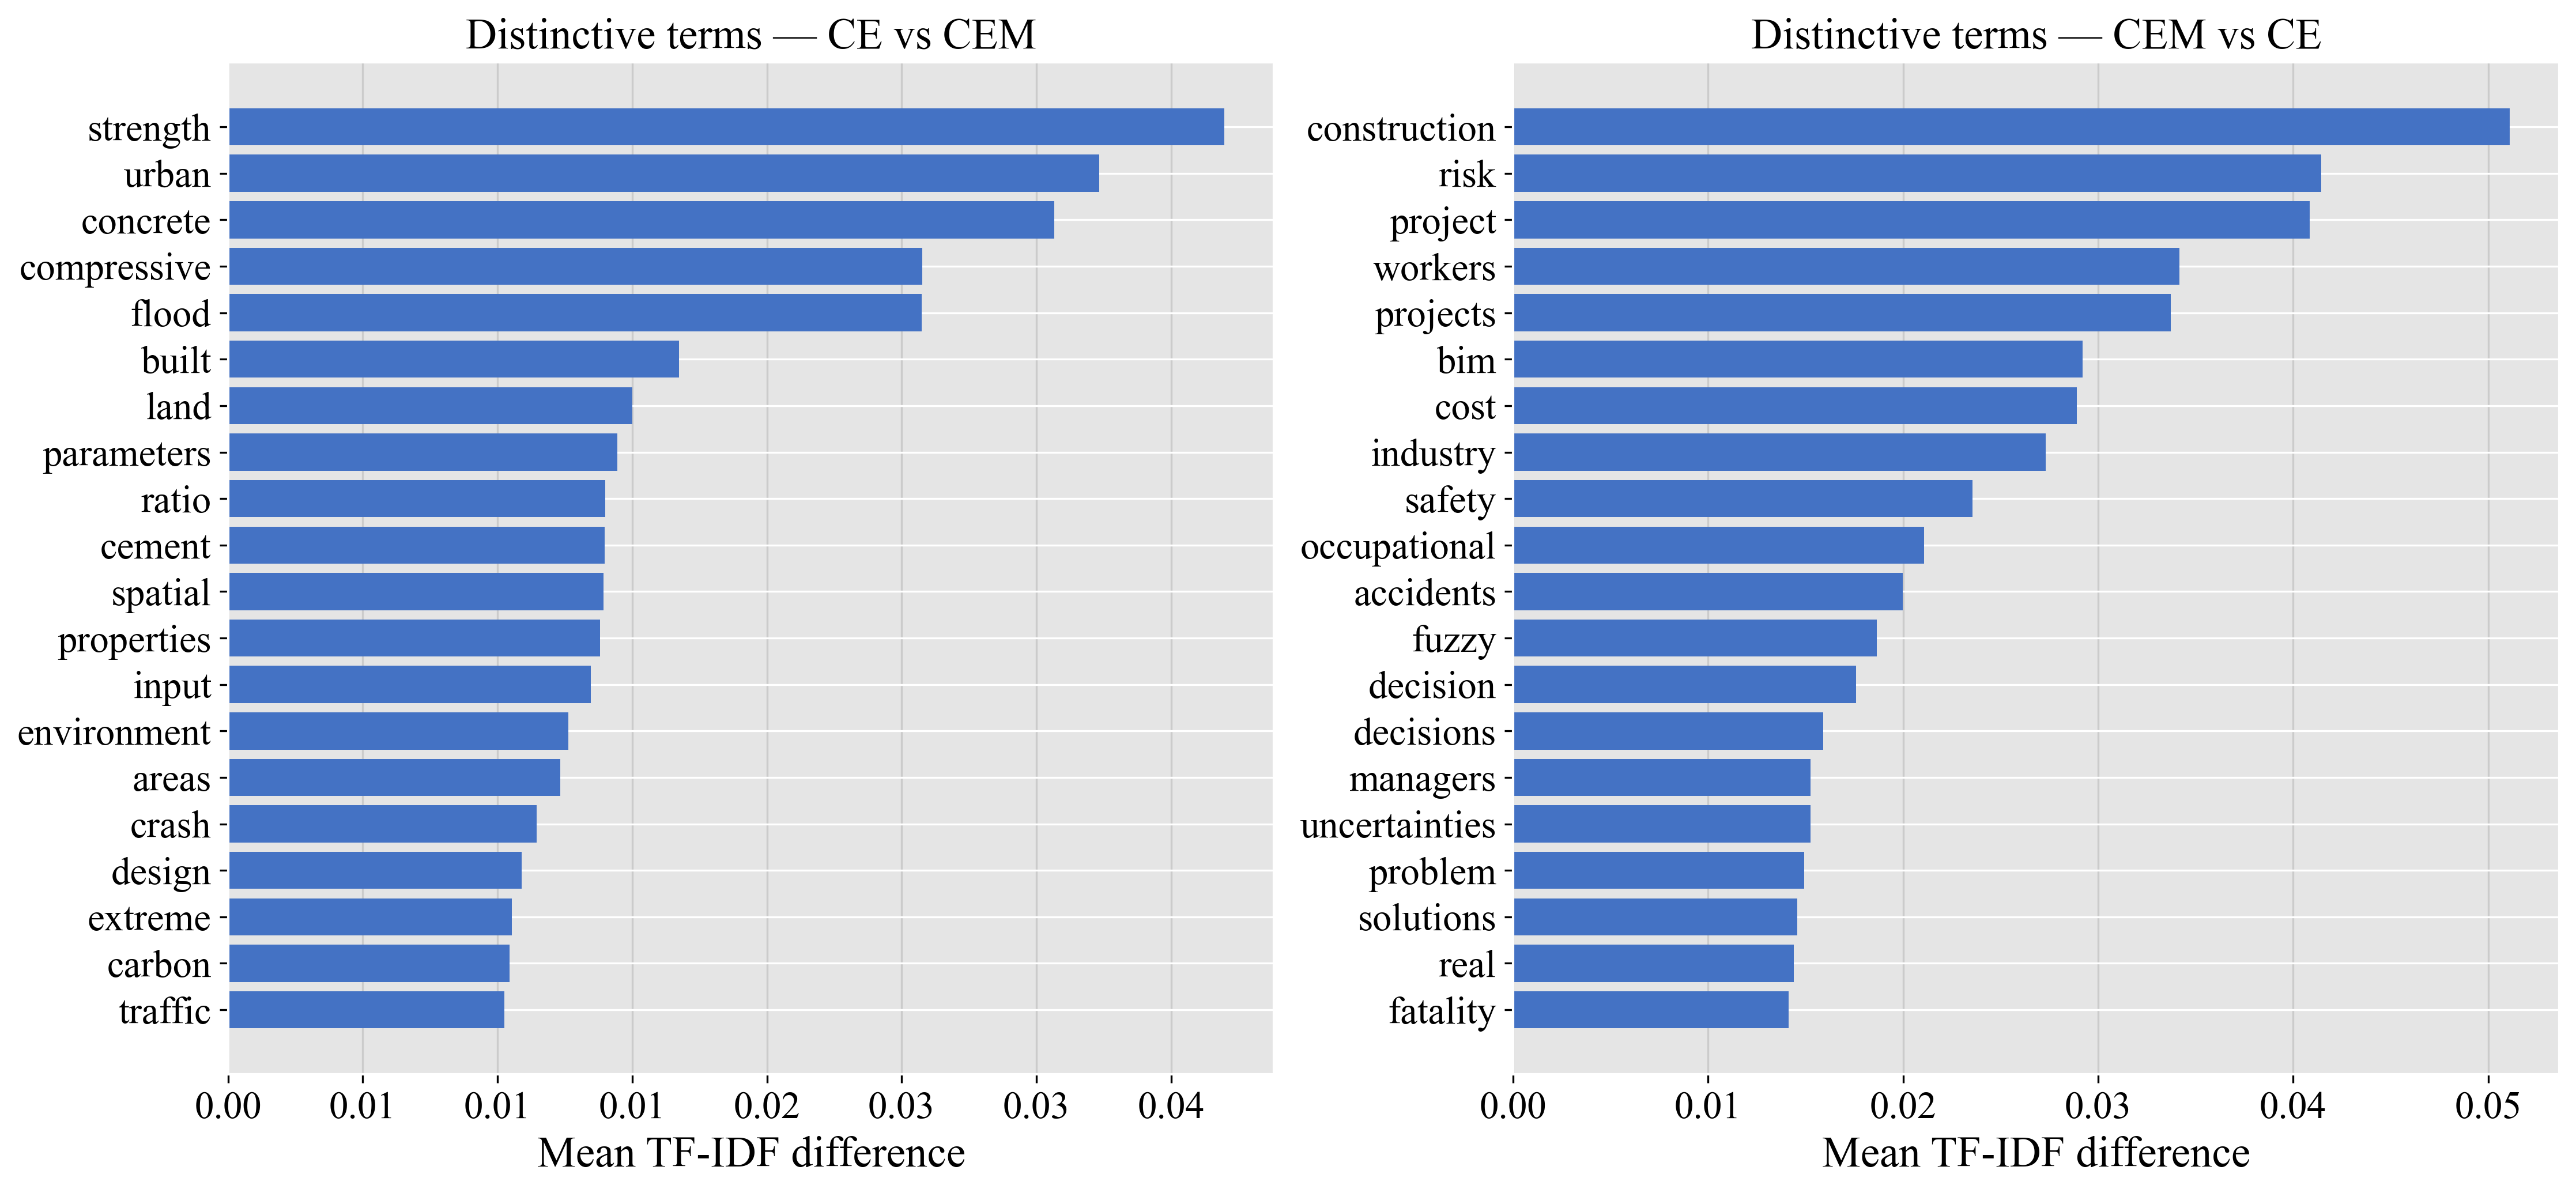

In [12]:
# === CE vs CEM — TF-IDF Distinctive Terms from Abstracts (final styled Times New Roman) ===
# Requirements: pandas, scikit-learn, matplotlib, nltk
# If needed: pip install scikit-learn nltk matplotlib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# --- Use ggplot style base ---
plt.style.use("ggplot")

# --- NLTK stopwords (download once if missing) ---
try:
    from nltk.corpus import stopwords
except Exception:
    import nltk
    nltk.download("stopwords")
    from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------- CONFIG --------------------
CSV_PATH      = "xai_references_labeled.csv"
FIELD_COL     = "field"
ABSTRACT_COL  = "abstract"

TOP_K         = 20
NGRAM_RANGE   = (1, 2)
MIN_DF        = 2
MAX_FEATURES  = 20000

DOMAIN_WHITELIST = {"bim", "ohs", "fem", "gnn", "cnn", "svm", "lstm", "gru"}

STOPWORDS_EN = set(stopwords.words("english"))

CUSTOM_STOPWORDS = {
    "the","and","for","this","with","that","are","was","were","from","all",
    "can","these","which","between","into","their","most","high",
    "elsevier","rights","reserved",
    "study","analysis","research","results","framework","approach","methods",
    "method","proposed","using","used","based","data","dataset","models","model",
    "performance","accuracy","variables","features","factors","findings","paper","work",
    "machine","learning","explainable","interpretable","additive","shap","shapley",
    "xgboost","artificial","intelligence","ai","deep","neural","network","networks",
    "algorithm","algorithms","prediction","predictive",
    "significant","different","however","time","making","important","key","existing",
    "include","including","across","due","best","among","critical","new","values",
    "enhance","improve","also","well","provide","provides","compared","level","levels",
    "process","processes","development","developed","insights","accurate","optimal",
    "support","understanding","inf"
}
STOPWORDS_ALL = STOPWORDS_EN | CUSTOM_STOPWORDS

# -------------------- HELPERS --------------------
def basic_clean(text: str) -> str:
    """Lowercase and keep letters/spaces only."""
    if pd.isna(text):
        return ""
    text = re.sub(r"[^a-zA-Z\s]", " ", str(text).lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text

def analyzer_fn(doc: str):
    """Custom analyzer: tokenize, drop stopwords, keep tokens >2 chars."""
    doc = basic_clean(doc)
    toks = []
    for t in doc.split():
        if t in STOPWORDS_ALL:
            continue
        if len(t) <= 3 and t not in DOMAIN_WHITELIST:
            continue
        toks.append(t)
    return toks

def top_distinctive_terms(tfidf, terms, y, target_label, other_label, topk=20):
    """Return DataFrame of top distinctive terms for target_label vs other_label."""
    target_mask = (y == target_label)
    other_mask  = (y == other_label)
    mean_target = tfidf[target_mask].mean(axis=0).A1
    mean_other  = tfidf[other_mask].mean(axis=0).A1
    diff = mean_target - mean_other
    order = np.argsort(-diff)[:topk]
    return pd.DataFrame({
        "term": terms[order],
        f"mean_{target_label}": mean_target[order],
        f"mean_{other_label}":  mean_other[order],
        "distinctiveness": diff[order]
    })

def plot_bars(df_terms, title, ax):
    """Consistent Times New Roman font and black text for all figure elements."""
    ax.barh(df_terms["term"][::-1], df_terms["distinctiveness"][::-1], color="#4472C4")
    ax.set_xlabel("Mean TF-IDF difference", fontsize=18, fontname="Times New Roman", color="black")
    ax.set_title(title, fontsize=18, fontname="Times New Roman", color="black")
    ax.grid(axis="x", alpha=0.25, color="gray")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # Ticks and labels styling
    ax.tick_params(axis='x', labelsize=16, colors="black")
    ax.tick_params(axis='y', labelsize=16, colors="black")
    
    # Apply Times New Roman to all tick labels
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontname("Times New Roman")
        lbl.set_color("black")

# -------------------- LOAD --------------------
df = pd.read_csv(CSV_PATH)
df = df[[FIELD_COL, ABSTRACT_COL]].dropna(subset=[ABSTRACT_COL]).copy()
df[FIELD_COL] = df[FIELD_COL].astype(str).str.strip().str.upper()
df = df[df[FIELD_COL].isin(["CE", "CEM"])]

# -------------------- VECTORIZE --------------------
vectorizer = TfidfVectorizer(
    analyzer=analyzer_fn,
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_features=MAX_FEATURES,
    lowercase=False,
    token_pattern=None
)
X = vectorizer.fit_transform(df[ABSTRACT_COL])
terms = np.array(vectorizer.get_feature_names_out())
y = df[FIELD_COL].to_numpy()

# -------------------- DISTINCTIVE TERMS --------------------
ce_vs_cem  = top_distinctive_terms(X, terms, y, "CE",  "CEM", topk=TOP_K)
cem_vs_ce  = top_distinctive_terms(X, terms, y, "CEM", "CE",  topk=TOP_K)

# -------------------- PRINT RESULTS --------------------
pd.set_option("display.max_colwidth", 60)
print("\nTop distinctive terms for CE (vs CEM) — TF-IDF mean difference")
print(ce_vs_cem.to_string(index=False))
print("\nTop distinctive terms for CEM (vs CE) — TF-IDF mean difference")
print(cem_vs_ce.to_string(index=False))

# -------------------- PLOT --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=300)

plot_bars(ce_vs_cem, "Distinctive terms — CE vs CEM", ax1)
plot_bars(cem_vs_ce, "Distinctive terms — CEM vs CE", ax2)

plt.tight_layout()
# plt.savefig("tfidf_distinctive_terms_CE_vs_CEM.tif", dpi=300, bbox_inches="tight")
plt.show()


C:\winapps\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(



Top distinctive terms for CE (vs CEM) — TF-IDF mean difference
       term  mean_CE  mean_CEM  distinctiveness
   strength 0.042111  0.003727         0.038384
      urban 0.035717  0.003142         0.032575
   concrete 0.042101  0.010462         0.031639
      flood 0.030202  0.000000         0.030202
compressive 0.026522  0.000000         0.026522
      crash 0.018720  0.000000         0.018720
  parameter 0.025695  0.007313         0.018382
   material 0.020249  0.003886         0.016363
       land 0.017736  0.002152         0.015584
       area 0.019032  0.003488         0.015544
      ratio 0.015462  0.000000         0.015462
      build 0.023676  0.008371         0.015305
   property 0.017234  0.002731         0.014504
     cement 0.014407  0.000000         0.014407
    spatial 0.014823  0.000979         0.013844
      input 0.018744  0.005156         0.013588
environment 0.020174  0.007715         0.012459
  aggregate 0.012546  0.001064         0.011482
       city 0.011270  0.

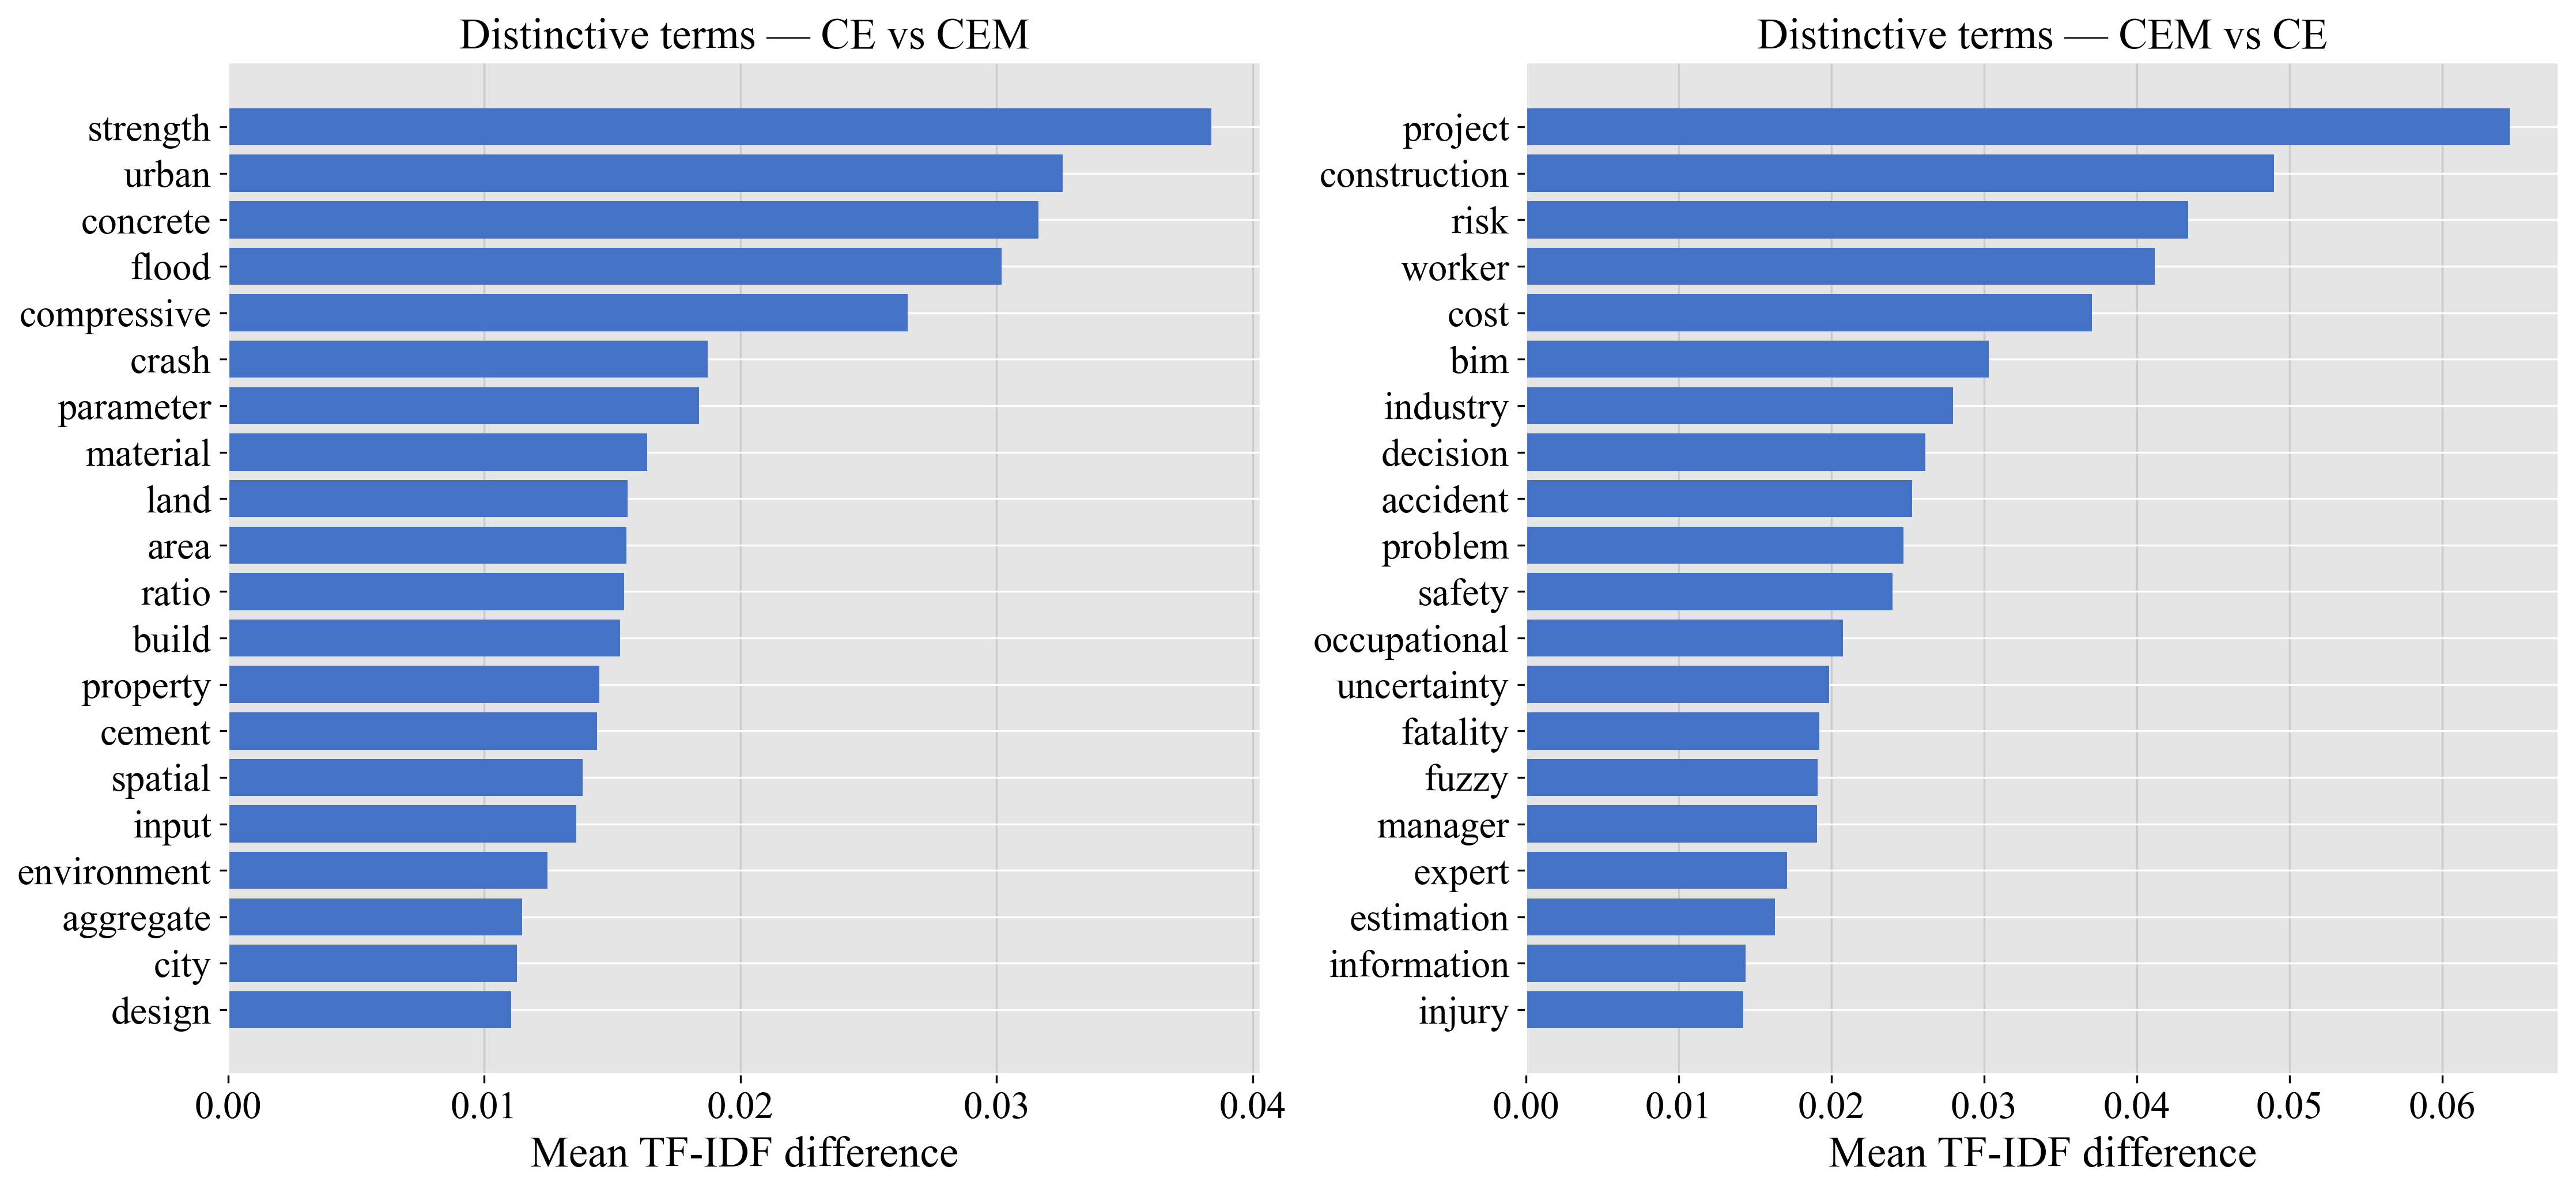

In [2]:
# === CE vs CEM — TF-IDF Distinctive Terms from Abstracts (lemmatized; Times New Roman) ===
# Requirements: pandas, scikit-learn, matplotlib, nltk
# If needed: pip install scikit-learn nltk matplotlib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# --- Use ggplot style base ---
plt.style.use("ggplot")

# --- NLTK stopwords + lemmatizer (download once if missing) ---
try:
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag
except Exception:
    import nltk
    nltk.download("stopwords")
    nltk.download("wordnet")
    nltk.download("omw-1.4")
    # POS tagger is optional; we try to use it if available
    try:
        nltk.download("averaged_perceptron_tagger")
    except Exception:
        pass
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------- CONFIG --------------------
CSV_PATH      = "xai_references_labeled.csv"
FIELD_COL     = "field"
ABSTRACT_COL  = "abstract"

TOP_K         = 20
NGRAM_RANGE   = (1, 2)
MIN_DF        = 2
MAX_FEATURES  = 20000

# Uppercase whitelist so we keep short technical tokens (kept in lowercase after cleaning)
DOMAIN_WHITELIST = {"bim", "ohs", "fem", "gnn", "cnn", "svm", "lstm", "gru"}

STOPWORDS_EN = set(stopwords.words("english"))

CUSTOM_STOPWORDS = {
    "the","and","for","this","with","that","are","was","were","from","all",
    "can","these","which","between","into","their","most","high",
    "elsevier","rights","reserved",
    "study","analysis","research","results","framework","approach","methods",
    "method","proposed","using","used","based","data","dataset","models","model",
    "performance","accuracy","variables","features","factors","findings","paper","work",
    "machine","learning","explainable","interpretable","additive","shap","shapley",
    "xgboost","artificial","intelligence","ai","deep","neural","network","networks",
    "algorithm","algorithms","prediction","predictive",
    "significant","different","however","time","making","important","key","existing",
    "include","including","across","due","best","among","critical","new","values",
    "enhance","improve","also","well","provide","provides","compared","level","levels",
    "process","processes","development","developed","insights","accurate","optimal",
    "support","understanding","inf"
}
STOPWORDS_ALL = STOPWORDS_EN | CUSTOM_STOPWORDS

# -------------------- HELPERS --------------------
def basic_clean(text: str) -> str:
    """Lowercase and keep letters/spaces only."""
    if pd.isna(text):
        return ""
    text = re.sub(r"[^a-zA-Z\s]", " ", str(text).lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Map NLTK POS tag to WordNet POS for better lemmatization
def _wn_pos(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  # default to noun

_lemmatizer = WordNetLemmatizer()

def _lemmatize_tokens(tokens):
    """Lemmatize with POS tags if tagger is available; otherwise noun-default."""
    try:
        tagged = pos_tag(tokens)
        return [_lemmatizer.lemmatize(tok, _wn_pos(pos)) for tok, pos in tagged]
    except Exception:
        return [_lemmatizer.lemmatize(tok) for tok in tokens]

def analyzer_fn(doc: str):
    """Custom analyzer: clean → tokenize → filter → **lemmatize** → filter short unless whitelisted."""
    doc = basic_clean(doc)
    if not doc:
        return []
    # First pass: rough tokenization + stopword filter
    toks = [t for t in doc.split() if t not in STOPWORDS_ALL]
    if not toks:
        return []
    # Lemmatize (collapses project/projects, decision/decisions, etc.)
    toks = _lemmatize_tokens(toks)
    # Final pass: keep tokens >3 chars unless in domain whitelist
    kept = []
    for t in toks:
        if len(t) <= 3 and t not in DOMAIN_WHITELIST:
            continue
        kept.append(t)
    return kept

def top_distinctive_terms(tfidf, terms, y, target_label, other_label, topk=20):
    """Return DataFrame of top distinctive terms for target_label vs other_label."""
    target_mask = (y == target_label)
    other_mask  = (y == other_label)
    mean_target = tfidf[target_mask].mean(axis=0).A1
    mean_other  = tfidf[other_mask].mean(axis=0).A1
    diff = mean_target - mean_other
    order = np.argsort(-diff)[:topk]
    return pd.DataFrame({
        "term": terms[order],
        f"mean_{target_label}": mean_target[order],
        f"mean_{other_label}":  mean_other[order],
        "distinctiveness": diff[order]
    })

def plot_bars(df_terms, title, ax):
    """Consistent Times New Roman font and black text for all figure elements."""
    ax.barh(df_terms["term"][::-1], df_terms["distinctiveness"][::-1], color="#4472C4")
    ax.set_xlabel("Mean TF-IDF difference", fontsize=18, fontname="Times New Roman", color="black")
    ax.set_title(title, fontsize=18, fontname="Times New Roman", color="black")
    ax.grid(axis="x", alpha=0.25, color="gray")
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Ticks and labels styling
    ax.tick_params(axis='x', labelsize=16, colors="black")
    ax.tick_params(axis='y', labelsize=16, colors="black")

    # Apply Times New Roman to all tick labels
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontname("Times New Roman")
        lbl.set_color("black")

# -------------------- LOAD --------------------
df = pd.read_csv(CSV_PATH)
df = df[[FIELD_COL, ABSTRACT_COL]].dropna(subset=[ABSTRACT_COL]).copy()
df[FIELD_COL] = df[FIELD_COL].astype(str).str.strip().str.upper()
df = df[df[FIELD_COL].isin(["CE", "CEM"])]

# -------------------- VECTORIZE (after normalization/lemmatization) --------------------
vectorizer = TfidfVectorizer(
    analyzer=analyzer_fn,
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_features=MAX_FEATURES,
    lowercase=False,   # we already lowercased in basic_clean
    token_pattern=None # required when using custom analyzer
)
X = vectorizer.fit_transform(df[ABSTRACT_COL])
terms = np.array(vectorizer.get_feature_names_out())
y = df[FIELD_COL].to_numpy()

# -------------------- DISTINCTIVE TERMS --------------------
ce_vs_cem  = top_distinctive_terms(X, terms, y, "CE",  "CEM", topk=TOP_K)
cem_vs_ce  = top_distinctive_terms(X, terms, y, "CEM", "CE",  topk=TOP_K)

# -------------------- PRINT RESULTS --------------------
pd.set_option("display.max_colwidth", 60)
print("\nTop distinctive terms for CE (vs CEM) — TF-IDF mean difference")
print(ce_vs_cem.to_string(index=False))
print("\nTop distinctive terms for CEM (vs CE) — TF-IDF mean difference")
print(cem_vs_ce.to_string(index=False))

# -------------------- PLOT --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), dpi=300)
plot_bars(ce_vs_cem, "Distinctive terms — CE vs CEM", ax1)
plot_bars(cem_vs_ce, "Distinctive terms — CEM vs CE", ax2)
plt.tight_layout()
# plt.savefig("tfidf_distinctive_terms_CE_vs_CEM_lemmatized.tif", dpi=300, bbox_inches="tight")
plt.show()


C:\winapps\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(



Top distinctive terms for CE (vs CEM) — TF-IDF mean difference
       term  mean_CE  mean_CEM  distinctiveness
   strength 0.042111  0.003727         0.038384
      urban 0.035717  0.003142         0.032575
   concrete 0.042101  0.010462         0.031639
      flood 0.030202  0.000000         0.030202
compressive 0.026522  0.000000         0.026522
      crash 0.018720  0.000000         0.018720
  parameter 0.025695  0.007313         0.018382
   material 0.020249  0.003886         0.016363
       land 0.017736  0.002152         0.015584
       area 0.019032  0.003488         0.015544
      ratio 0.015462  0.000000         0.015462
      build 0.023676  0.008371         0.015305
   property 0.017234  0.002731         0.014504
     cement 0.014407  0.000000         0.014407
    spatial 0.014823  0.000979         0.013844
      input 0.018744  0.005156         0.013588
environment 0.020174  0.007715         0.012459
  aggregate 0.012546  0.001064         0.011482
       city 0.011270  0.

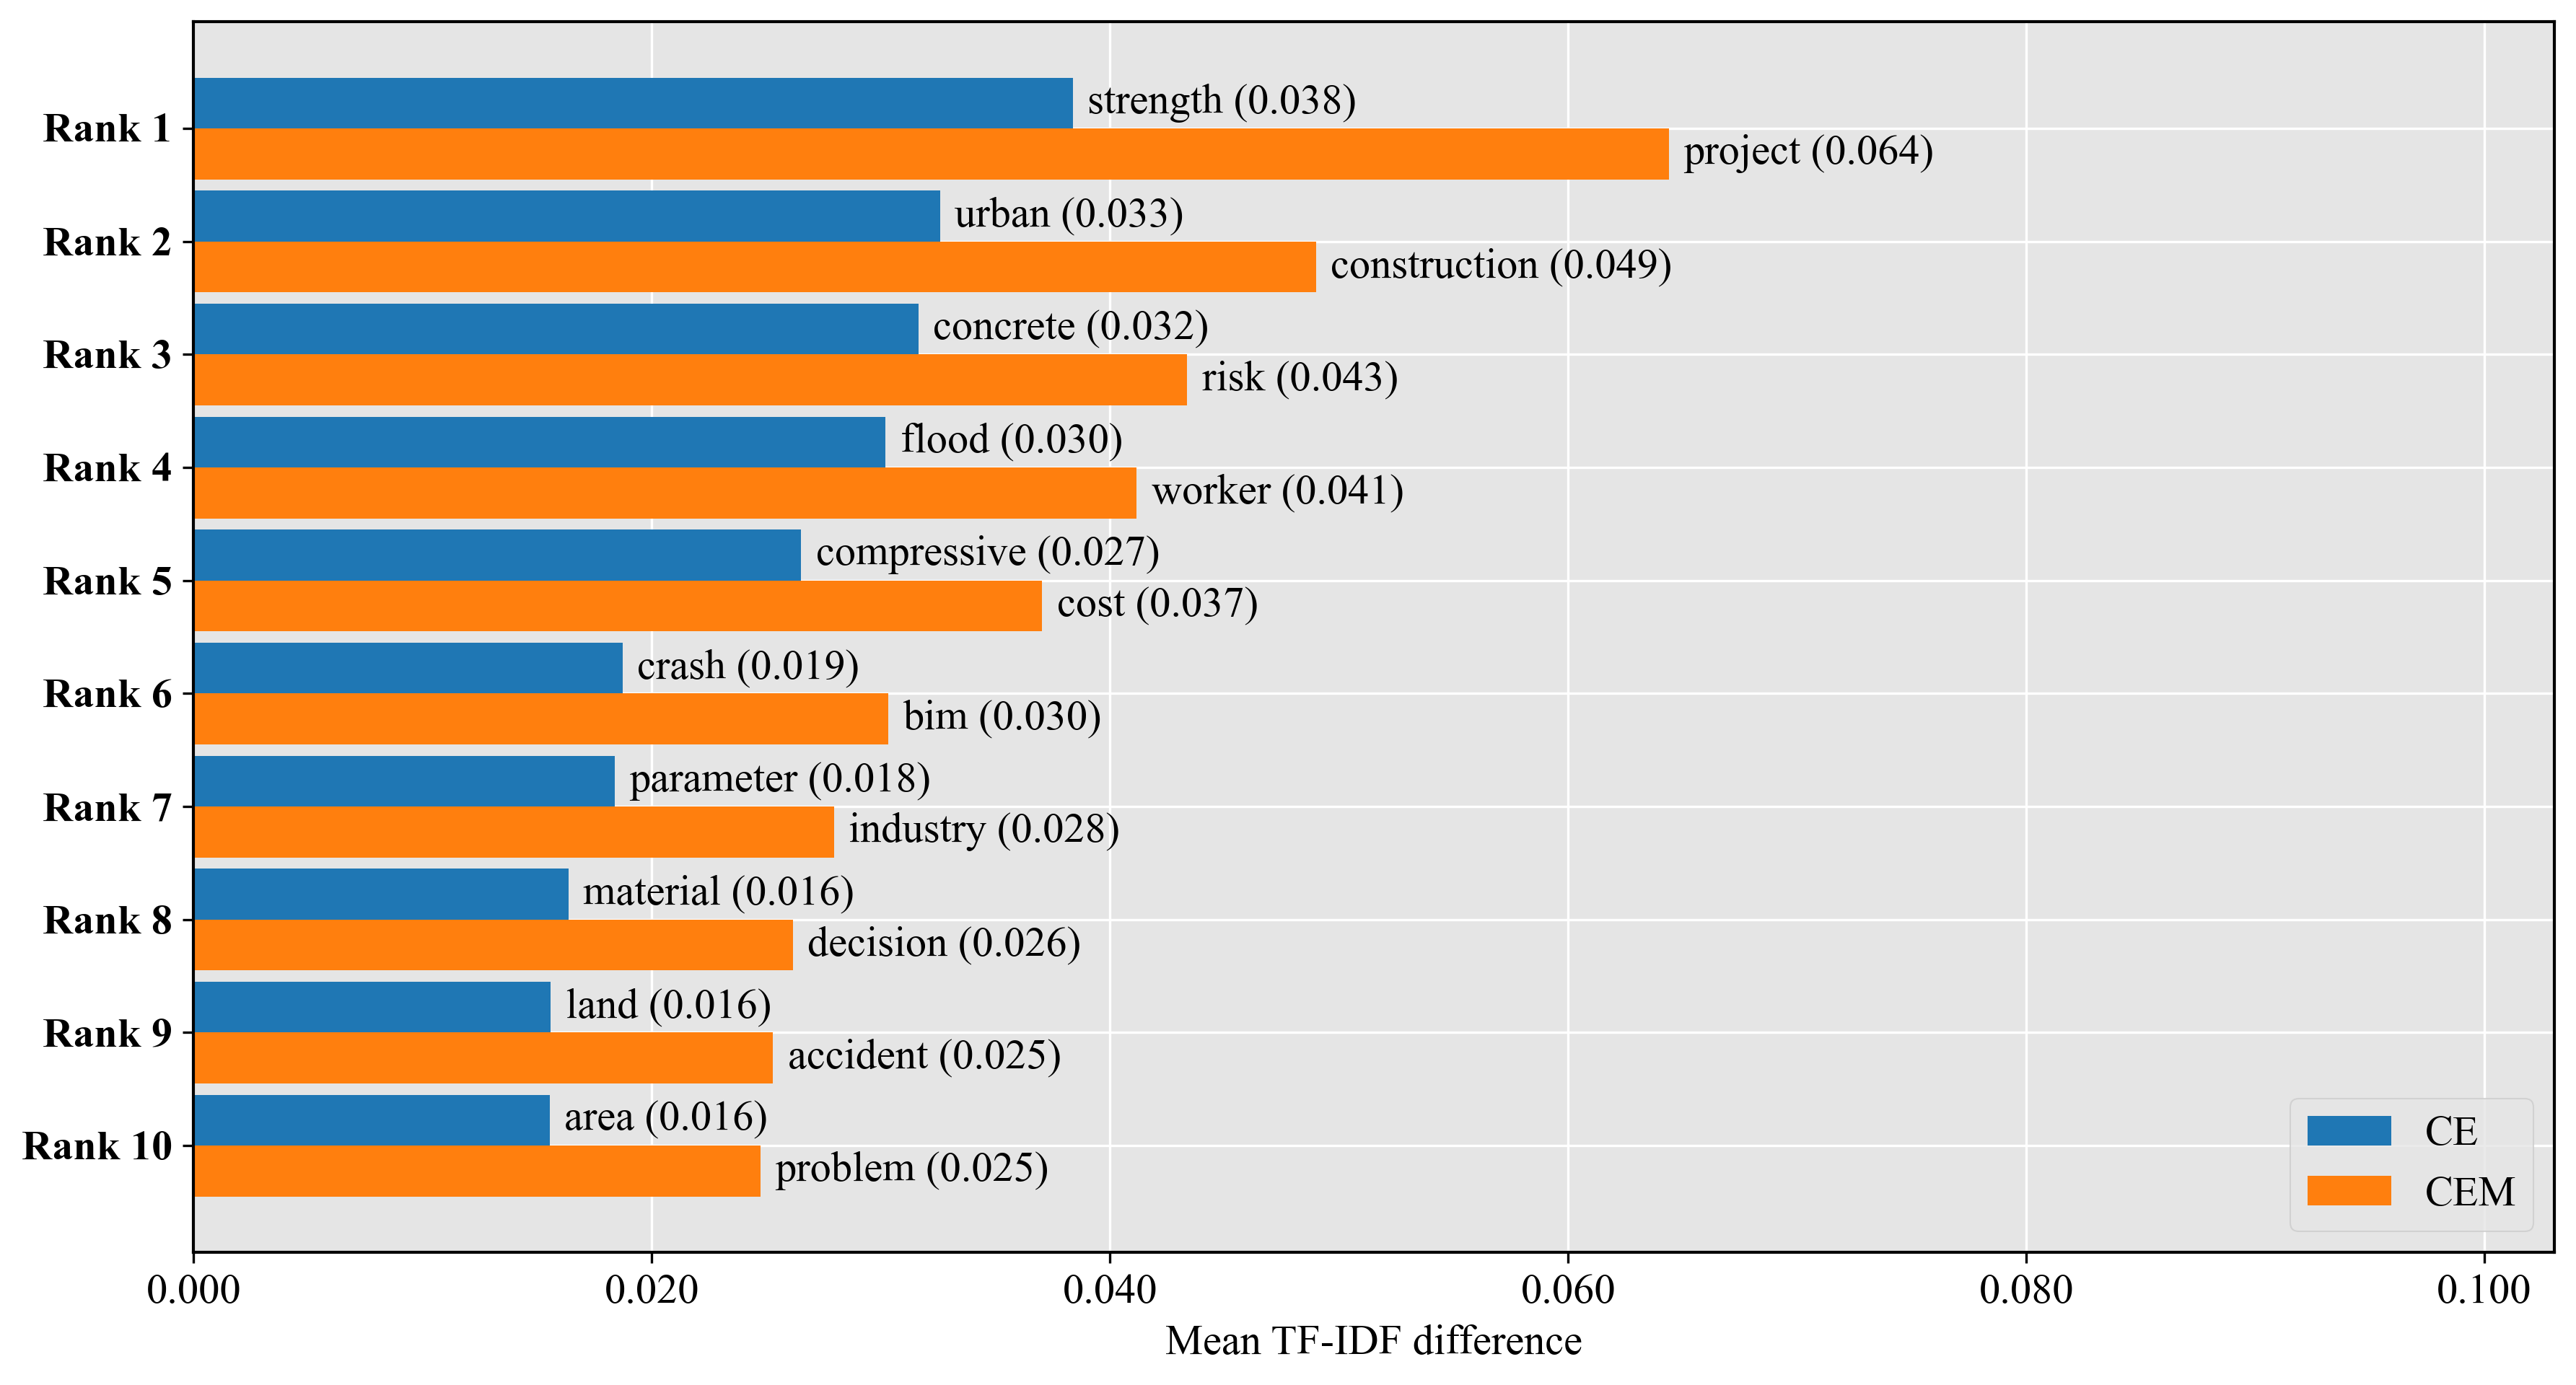

In [2]:
# === CE vs CEM — TF-IDF Distinctive Terms from Abstracts (lemmatized; Times New Roman) ===
# Requirements: pandas, scikit-learn, matplotlib, nltk
# If needed: pip install scikit-learn nltk matplotlib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

# --- Use ggplot style base ---
plt.style.use("ggplot")

# --- Global font / color style (as in your journal plot) ---
mpl.rcParams["font.family"]     = "Times New Roman"
mpl.rcParams["text.color"]      = "black"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"]  = "black"
mpl.rcParams["axes.titlecolor"] = "black"
mpl.rcParams["xtick.color"]     = "black"
mpl.rcParams["ytick.color"]     = "black"

# --- NLTK stopwords + lemmatizer (download once if missing) ---
try:
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag
except Exception:
    import nltk
    nltk.download("stopwords")
    nltk.download("wordnet")
    nltk.download("omw-1.4")
    try:
        nltk.download("averaged_perceptron_tagger")
    except Exception:
        pass
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------- CONFIG --------------------
CSV_PATH      = "xai_references_labeled.csv"
FIELD_COL     = "field"
ABSTRACT_COL  = "abstract"

TOP_K         = 20          # compute this many distinctive terms
NGRAM_RANGE   = (1, 2)
MIN_DF        = 2
MAX_FEATURES  = 20000

# how many ranks to show in the final figure (Rank 1..K)
RANK_K        = 10          # set to TOP_K if you want all of them

# Uppercase whitelist so we keep short technical tokens (kept in lowercase after cleaning)
DOMAIN_WHITELIST = {"bim", "ohs", "fem", "gnn", "cnn", "svm", "lstm", "gru"}

STOPWORDS_EN = set(stopwords.words("english"))

CUSTOM_STOPWORDS = {
    "the", "and", "for", "this", "with", "that", "are", "was", "were", "from", "all",
    "can", "these", "which", "between", "into", "their", "most", "high",
    "elsevier", "rights", "reserved",
    "study", "analysis", "research", "results", "framework", "approach", "methods",
    "method", "proposed", "using", "used", "based", "data", "dataset", "models", "model",
    "performance", "accuracy", "variables", "features", "factors", "findings", "paper", "work",
    "machine", "learning", "explainable", "interpretable", "additive", "shap", "shapley",
    "xgboost", "artificial", "intelligence", "ai", "deep", "neural", "network", "networks",
    "algorithm", "algorithms", "prediction", "predictive",
    "significant", "different", "however", "time", "making", "important", "key", "existing",
    "include", "including", "across", "due", "best", "among", "critical", "new", "values",
    "enhance", "improve", "also", "well", "provide", "provides", "compared", "level", "levels",
    "process", "processes", "development", "developed", "insights", "accurate", "optimal",
    "support", "understanding", "inf"
}
STOPWORDS_ALL = STOPWORDS_EN | CUSTOM_STOPWORDS

# -------------------- HELPERS --------------------
def basic_clean(text: str) -> str:
    """Lowercase and keep letters/spaces only."""
    if pd.isna(text):
        return ""
    text = re.sub(r"[^a-zA-Z\s]", " ", str(text).lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Map NLTK POS tag to WordNet POS for better lemmatization
def _wn_pos(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  # default to noun

_lemmatizer = WordNetLemmatizer()

def _lemmatize_tokens(tokens):
    """Lemmatize with POS tags if tagger is available; otherwise noun-default."""
    try:
        tagged = pos_tag(tokens)
        return [_lemmatizer.lemmatize(tok, _wn_pos(pos)) for tok, pos in tagged]
    except Exception:
        return [_lemmatizer.lemmatize(tok) for tok in tokens]

def analyzer_fn(doc: str):
    """
    Custom analyzer:
    clean → tokenize → stopword filter → lemmatize → filter short tokens
    unless whitelisted.
    """
    doc = basic_clean(doc)
    if not doc:
        return []
    toks = [t for t in doc.split() if t not in STOPWORDS_ALL]
    if not toks:
        return []
    toks = _lemmatize_tokens(toks)
    kept = []
    for t in toks:
        if len(t) <= 3 and t not in DOMAIN_WHITELIST:
            continue
        kept.append(t)
    return kept

def top_distinctive_terms(tfidf, terms, y, target_label, other_label, topk=20):
    """Return DataFrame of top distinctive terms for target_label vs other_label."""
    target_mask = (y == target_label)
    other_mask  = (y == other_label)
    mean_target = tfidf[target_mask].mean(axis=0).A1
    mean_other  = tfidf[other_mask].mean(axis=0).A1
    diff = mean_target - mean_other
    order = np.argsort(-diff)[:topk]
    return pd.DataFrame({
        "term": terms[order],
        f"mean_{target_label}": mean_target[order],
        f"mean_{other_label}":  mean_other[order],
        "distinctiveness": diff[order]
    })

def pad_terms(vals, terms, k):
    """Pad values and term labels to length k."""
    vals = np.asarray(vals, dtype=float)
    terms = list(terms)
    if len(vals) < k:
        vals = np.pad(vals, (0, k - len(vals)), constant_values=0.0)
    else:
        vals = vals[:k]
    if len(terms) < k:
        terms = terms + [""] * (k - len(terms))
    else:
        terms = terms[:k]
    return vals, terms

# -------------------- LOAD --------------------
df = pd.read_csv(CSV_PATH)
df = df[[FIELD_COL, ABSTRACT_COL]].dropna(subset=[ABSTRACT_COL]).copy()
df[FIELD_COL] = df[FIELD_COL].astype(str).str.strip().str.upper()
df = df[df[FIELD_COL].isin(["CE", "CEM"])]

# -------------------- VECTORIZE (after normalization/lemmatization) --------------------
vectorizer = TfidfVectorizer(
    analyzer=analyzer_fn,
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_features=MAX_FEATURES,
    lowercase=False,   # we already lowercased in basic_clean
    token_pattern=None # required when using custom analyzer
)
X = vectorizer.fit_transform(df[ABSTRACT_COL])
terms = np.array(vectorizer.get_feature_names_out())
y = df[FIELD_COL].to_numpy()

# -------------------- DISTINCTIVE TERMS --------------------
ce_vs_cem = top_distinctive_terms(X, terms, y, "CE",  "CEM", topk=TOP_K)
cem_vs_ce = top_distinctive_terms(X, terms, y, "CEM", "CE",  topk=TOP_K)

# -------------------- PRINT RESULTS (optional) --------------------
pd.set_option("display.max_colwidth", 60)
print("\nTop distinctive terms for CE (vs CEM) — TF-IDF mean difference")
print(ce_vs_cem.to_string(index=False))
print("\nTop distinctive terms for CEM (vs CE) — TF-IDF mean difference")
print(cem_vs_ce.to_string(index=False))

# -------------------- PLOT (grouped ranks, CE vs CEM) --------------------
# Take top RANK_K from each list
ce_vals_raw  = ce_vs_cem["distinctiveness"].values
ce_terms_raw = ce_vs_cem["term"].values
cem_vals_raw = cem_vs_ce["distinctiveness"].values
cem_terms_raw= cem_vs_ce["term"].values

ce_vals,  ce_terms  = pad_terms(ce_vals_raw,  ce_terms_raw,  RANK_K)
cem_vals, cem_terms = pad_terms(cem_vals_raw, cem_terms_raw, RANK_K)

# Build rank axis
y_pos = np.arange(RANK_K)           # 0..K-1
ranks = np.arange(1, RANK_K + 1)    # 1..K

bar_height = 0.45
fig, ax = plt.subplots(figsize=(12, 0.45 * RANK_K + 2), dpi=300)

# Grouped horizontal bars
ax.barh(y_pos - bar_height/2, ce_vals,  height=bar_height,
        color="#1f77b4", label="CE")
ax.barh(y_pos + bar_height/2, cem_vals, height=bar_height,
        color="#ff7f0e", label="CEM")

# Rank labels
ax.set_yticks(y_pos)
ax.set_yticklabels([f"Rank {r}" for r in ranks], fontsize=14, fontweight="bold")

# Rank 1 at top
ax.invert_yaxis()

# Axis label
ax.set_xlabel("Mean TF-IDF difference", fontsize=14)

# Tick font sizes
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

# Format x-axis numbers
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# Expand x-limits with some margin for text labels
xmax = max(ce_vals.max(), cem_vals.max()) if (ce_vals.size and cem_vals.size) else 0
ax.set_xlim(0, xmax * 1.6 if xmax > 0 else 1)

# Text labels: "term (value)" on each bar
offset = xmax * 0.01 if xmax > 0 else 0.0005   # small horizontal gap
for yy, ce_v, cem_v, ce_t, cem_t in zip(y_pos, ce_vals, cem_vals, ce_terms, cem_terms):
    if ce_v > 0:
        ax.text(ce_v + offset, yy - bar_height/2,
                f"{ce_t} ({ce_v:.3f})",
                va="center", ha="left", fontsize=14)
    if cem_v > 0:
        cem_x = cem_v + offset
        # if values are very close, nudge CEM a bit more to the right
        if abs(cem_v - ce_v) < max(cem_v, 1e-8) * 0.05:
            cem_x += offset
        ax.text(cem_x, yy + bar_height/2,
                f"{cem_t} ({cem_v:.3f})",
                va="center", ha="left", fontsize=14)

# Legend
ax.legend(loc="lower right", fontsize=14)

plt.tight_layout()
# plt.savefig("tfidf_distinctive_terms_CE_vs_CEM_ranked.tif", dpi=300, bbox_inches="tight")
plt.show()


C:\winapps\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(



Top distinctive terms for CE (vs CEM) — TF-IDF mean difference
       term  mean_CE  mean_CEM  distinctiveness
   strength 0.042111  0.003727         0.038384
      urban 0.035717  0.003142         0.032575
   concrete 0.042101  0.010462         0.031639
      flood 0.030202  0.000000         0.030202
compressive 0.026522  0.000000         0.026522
      crash 0.018720  0.000000         0.018720
  parameter 0.025695  0.007313         0.018382
   material 0.020249  0.003886         0.016363
       land 0.017736  0.002152         0.015584
       area 0.019032  0.003488         0.015544
      ratio 0.015462  0.000000         0.015462
      build 0.023676  0.008371         0.015305
   property 0.017234  0.002731         0.014504
     cement 0.014407  0.000000         0.014407
    spatial 0.014823  0.000979         0.013844
      input 0.018744  0.005156         0.013588
environment 0.020174  0.007715         0.012459
  aggregate 0.012546  0.001064         0.011482
       city 0.011270  0.

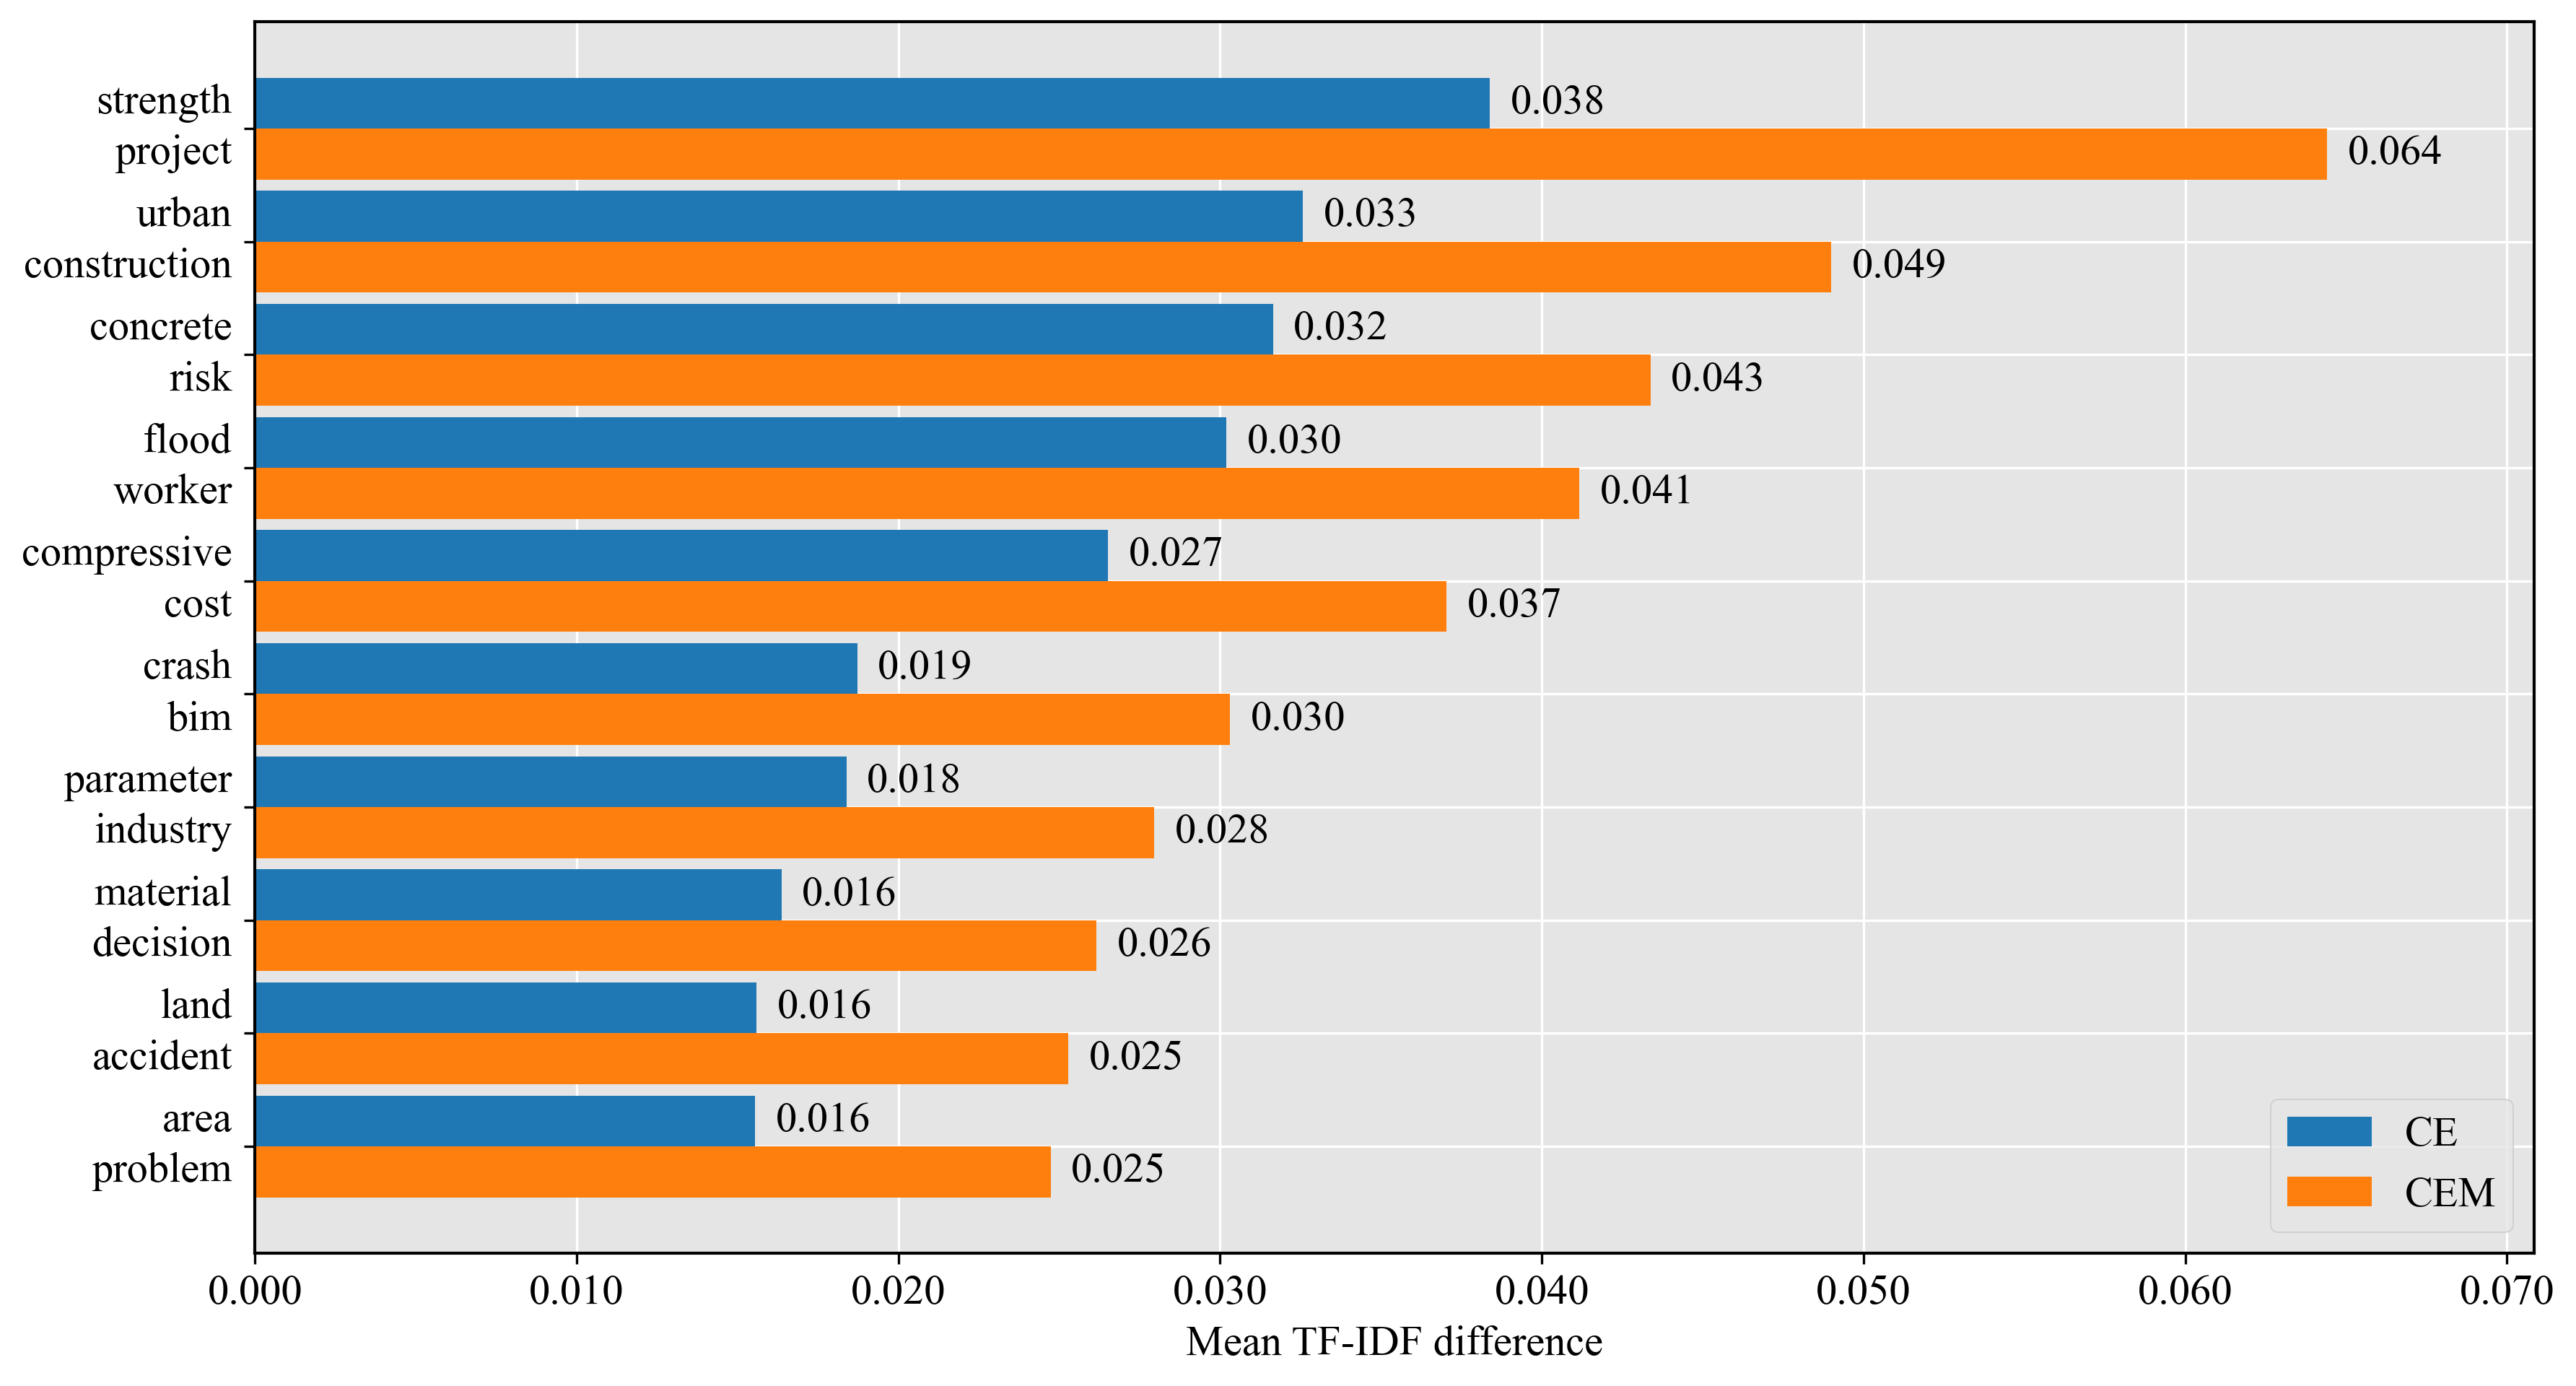

In [14]:
# === CE vs CEM — TF-IDF Distinctive Terms from Abstracts (lemmatized; Times New Roman) ===
# Requirements: pandas, scikit-learn, matplotlib, nltk
# If needed: pip install scikit-learn nltk matplotlib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

# --- Use ggplot style base ---
plt.style.use("ggplot")

# --- Global font / color style (as in your journal plot) ---
mpl.rcParams["font.family"]     = "Times New Roman"
mpl.rcParams["text.color"]      = "black"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"]  = "black"
mpl.rcParams["axes.titlecolor"] = "black"
mpl.rcParams["xtick.color"]     = "black"
mpl.rcParams["ytick.color"]     = "black"

# --- NLTK stopwords + lemmatizer (download once if missing) ---
try:
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag
except Exception:
    import nltk
    nltk.download("stopwords")
    nltk.download("wordnet")
    nltk.download("omw-1.4")
    try:
        nltk.download("averaged_perceptron_tagger")
    except Exception:
        pass
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------- CONFIG --------------------
CSV_PATH      = "xai_references_labeled.csv"
FIELD_COL     = "field"
ABSTRACT_COL  = "abstract"

TOP_K         = 20          # compute this many distinctive terms
NGRAM_RANGE   = (1, 2)
MIN_DF        = 2
MAX_FEATURES  = 20000

# how many ranks to show in the final figure (Rank 1..K)
RANK_K        = 10          # set to TOP_K if you want all of them

# Uppercase whitelist so we keep short technical tokens (kept in lowercase after cleaning)
DOMAIN_WHITELIST = {"bim", "ohs", "fem", "gnn", "cnn", "svm", "lstm", "gru"}

STOPWORDS_EN = set(stopwords.words("english"))

CUSTOM_STOPWORDS = {
    "the", "and", "for", "this", "with", "that", "are", "was", "were", "from", "all",
    "can", "these", "which", "between", "into", "their", "most", "high",
    "elsevier", "rights", "reserved",
    "study", "analysis", "research", "results", "framework", "approach", "methods",
    "method", "proposed", "using", "used", "based", "data", "dataset", "models", "model",
    "performance", "accuracy", "variables", "features", "factors", "findings", "paper", "work",
    "machine", "learning", "explainable", "interpretable", "additive", "shap", "shapley",
    "xgboost", "artificial", "intelligence", "ai", "deep", "neural", "network", "networks",
    "algorithm", "algorithms", "prediction", "predictive",
    "significant", "different", "however", "time", "making", "important", "key", "existing",
    "include", "including", "across", "due", "best", "among", "critical", "new", "values",
    "enhance", "improve", "also", "well", "provide", "provides", "compared", "level", "levels",
    "process", "processes", "development", "developed", "insights", "accurate", "optimal",
    "support", "understanding", "inf"
}
STOPWORDS_ALL = STOPWORDS_EN | CUSTOM_STOPWORDS

# -------------------- HELPERS --------------------
def basic_clean(text: str) -> str:
    """Lowercase and keep letters/spaces only."""
    if pd.isna(text):
        return ""
    text = re.sub(r"[^a-zA-Z\s]", " ", str(text).lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Map NLTK POS tag to WordNet POS for better lemmatization
def _wn_pos(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  # default to noun

_lemmatizer = WordNetLemmatizer()

def _lemmatize_tokens(tokens):
    """Lemmatize with POS tags if tagger is available; otherwise noun-default."""
    try:
        tagged = pos_tag(tokens)
        return [_lemmatizer.lemmatize(tok, _wn_pos(pos)) for tok, pos in tagged]
    except Exception:
        return [_lemmatizer.lemmatize(tok) for tok in tokens]

def analyzer_fn(doc: str):
    """
    Custom analyzer:
    clean → tokenize → stopword filter → lemmatize → filter short tokens
    unless whitelisted.
    """
    doc = basic_clean(doc)
    if not doc:
        return []
    toks = [t for t in doc.split() if t not in STOPWORDS_ALL]
    if not toks:
        return []
    toks = _lemmatize_tokens(toks)
    kept = []
    for t in toks:
        if len(t) <= 3 and t not in DOMAIN_WHITELIST:
            continue
        kept.append(t)
    return kept

def top_distinctive_terms(tfidf, terms, y, target_label, other_label, topk=20):
    """Return DataFrame of top distinctive terms for target_label vs other_label."""
    target_mask = (y == target_label)
    other_mask  = (y == other_label)
    mean_target = tfidf[target_mask].mean(axis=0).A1
    mean_other  = tfidf[other_mask].mean(axis=0).A1
    diff = mean_target - mean_other
    order = np.argsort(-diff)[:topk]
    return pd.DataFrame({
        "term": terms[order],
        f"mean_{target_label}": mean_target[order],
        f"mean_{other_label}":  mean_other[order],
        "distinctiveness": diff[order]
    })

def pad_terms(vals, terms, k):
    """Pad values and term labels to length k."""
    vals = np.asarray(vals, dtype=float)
    terms = list(terms)
    if len(vals) < k:
        vals = np.pad(vals, (0, k - len(vals)), constant_values=0.0)
    else:
        vals = vals[:k]
    if len(terms) < k:
        terms = terms + [""] * (k - len(terms))
    else:
        terms = terms[:k]
    return vals, terms

# -------------------- LOAD --------------------
df = pd.read_csv(CSV_PATH)
df = df[[FIELD_COL, ABSTRACT_COL]].dropna(subset=[ABSTRACT_COL]).copy()
df[FIELD_COL] = df[FIELD_COL].astype(str).str.strip().str.upper()
df = df[df[FIELD_COL].isin(["CE", "CEM"])]

# -------------------- VECTORIZE (after normalization/lemmatization) --------------------
vectorizer = TfidfVectorizer(
    analyzer=analyzer_fn,
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_features=MAX_FEATURES,
    lowercase=False,   # we already lowercased in basic_clean
    token_pattern=None # required when using custom analyzer
)
X = vectorizer.fit_transform(df[ABSTRACT_COL])
terms = np.array(vectorizer.get_feature_names_out())
y = df[FIELD_COL].to_numpy()

# -------------------- DISTINCTIVE TERMS --------------------
ce_vs_cem = top_distinctive_terms(X, terms, y, "CE",  "CEM", topk=TOP_K)
cem_vs_ce = top_distinctive_terms(X, terms, y, "CEM", "CE",  topk=TOP_K)

# -------------------- PRINT RESULTS (optional) --------------------
pd.set_option("display.max_colwidth", 60)
print("\nTop distinctive terms for CE (vs CEM) — TF-IDF mean difference")
print(ce_vs_cem.to_string(index=False))
print("\nTop distinctive terms for CEM (vs CE) — TF-IDF mean difference")
print(cem_vs_ce.to_string(index=False))

# -------------------- PLOT (grouped terms, CE vs CEM) --------------------
# Take top RANK_K from each list
ce_vals_raw  = ce_vs_cem["distinctiveness"].values
ce_terms_raw = ce_vs_cem["term"].values
cem_vals_raw = cem_vs_ce["distinctiveness"].values
cem_terms_raw= cem_vs_ce["term"].values

ce_vals,  ce_terms  = pad_terms(ce_vals_raw,  ce_terms_raw,  RANK_K)
cem_vals, cem_terms = pad_terms(cem_vals_raw, cem_terms_raw, RANK_K)

# Build y positions
y_pos = np.arange(RANK_K)           # 0..K-1

bar_height = 0.45
fig, ax = plt.subplots(figsize=(12, 0.45 * RANK_K + 2), dpi=300)

# Grouped horizontal bars
ax.barh(y_pos - bar_height/2, ce_vals,  height=bar_height,
        color="#1f77b4", label="CE")
ax.barh(y_pos + bar_height/2, cem_vals, height=bar_height,
        color="#ff7f0e", label="CEM")

# Remove y-tick labels (we will write term names manually)
ax.set_yticks(y_pos)
ax.set_yticklabels([""] * RANK_K)

# Rank 1 (top pair) at top
ax.invert_yaxis()

# Axis label
ax.set_xlabel("Mean TF-IDF difference", fontsize=14)

# Tick font sizes
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

# Format x-axis numbers
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# Expand x-limits with some margin for text labels
xmax = max(ce_vals.max(), cem_vals.max()) if (ce_vals.size and cem_vals.size) else 0
ax.set_xlim(0, xmax * 1.1)

# Left-side labels: just the term names (no numbers)
for yy, ce_t, cem_t in zip(y_pos, ce_terms, cem_terms):
    if ce_t:
        ax.text(-0.01, yy - bar_height/2, ce_t,
                va="center", ha="right", fontsize=14,
                transform=ax.get_yaxis_transform())
    if cem_t:
        ax.text(-0.01, yy + bar_height/2, cem_t,
                va="center", ha="right", fontsize=14,
                transform=ax.get_yaxis_transform())
        
# Right-side labels at bar ends: term (value) — keep as before
offset = xmax * 0.01 if xmax > 0 else 0.0005   # small horizontal gap
for yy, ce_v, cem_v, ce_t, cem_t in zip(y_pos, ce_vals, cem_vals, ce_terms, cem_terms):
    if ce_v > 0:
        ax.text(ce_v + offset, yy - bar_height/2,
                f"{ce_v:.3f}",
                va="center", ha="left", fontsize=14)
    if cem_v > 0:
        cem_x = cem_v + offset
        if abs(cem_v - ce_v) < max(cem_v, 1e-8) * 0.05:
            cem_x += offset
        ax.text(cem_x, yy + bar_height/2,
                f"{cem_v:.3f}",
                va="center", ha="left", fontsize=14)


# Legend
ax.legend(loc="lower right", fontsize=14)

plt.tight_layout()
# plt.savefig("tfidf_distinctive_terms_CE_vs_CEM_terms_left.tif", dpi=300, bbox_inches="tight")
plt.show()


C:\winapps\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(



Top distinctive terms for CE (vs CEM) — TF-IDF mean difference
       term  mean_CE  mean_CEM  distinctiveness
   strength 0.042111  0.003727         0.038384
      urban 0.035717  0.003142         0.032575
   concrete 0.042101  0.010462         0.031639
      flood 0.030202  0.000000         0.030202
compressive 0.026522  0.000000         0.026522
      crash 0.018720  0.000000         0.018720
  parameter 0.025695  0.007313         0.018382
   material 0.020249  0.003886         0.016363
       land 0.017736  0.002152         0.015584
       area 0.019032  0.003488         0.015544
      ratio 0.015462  0.000000         0.015462
      build 0.023676  0.008371         0.015305
   property 0.017234  0.002731         0.014504
     cement 0.014407  0.000000         0.014407
    spatial 0.014823  0.000979         0.013844
      input 0.018744  0.005156         0.013588
environment 0.020174  0.007715         0.012459
  aggregate 0.012546  0.001064         0.011482
       city 0.011270  0.

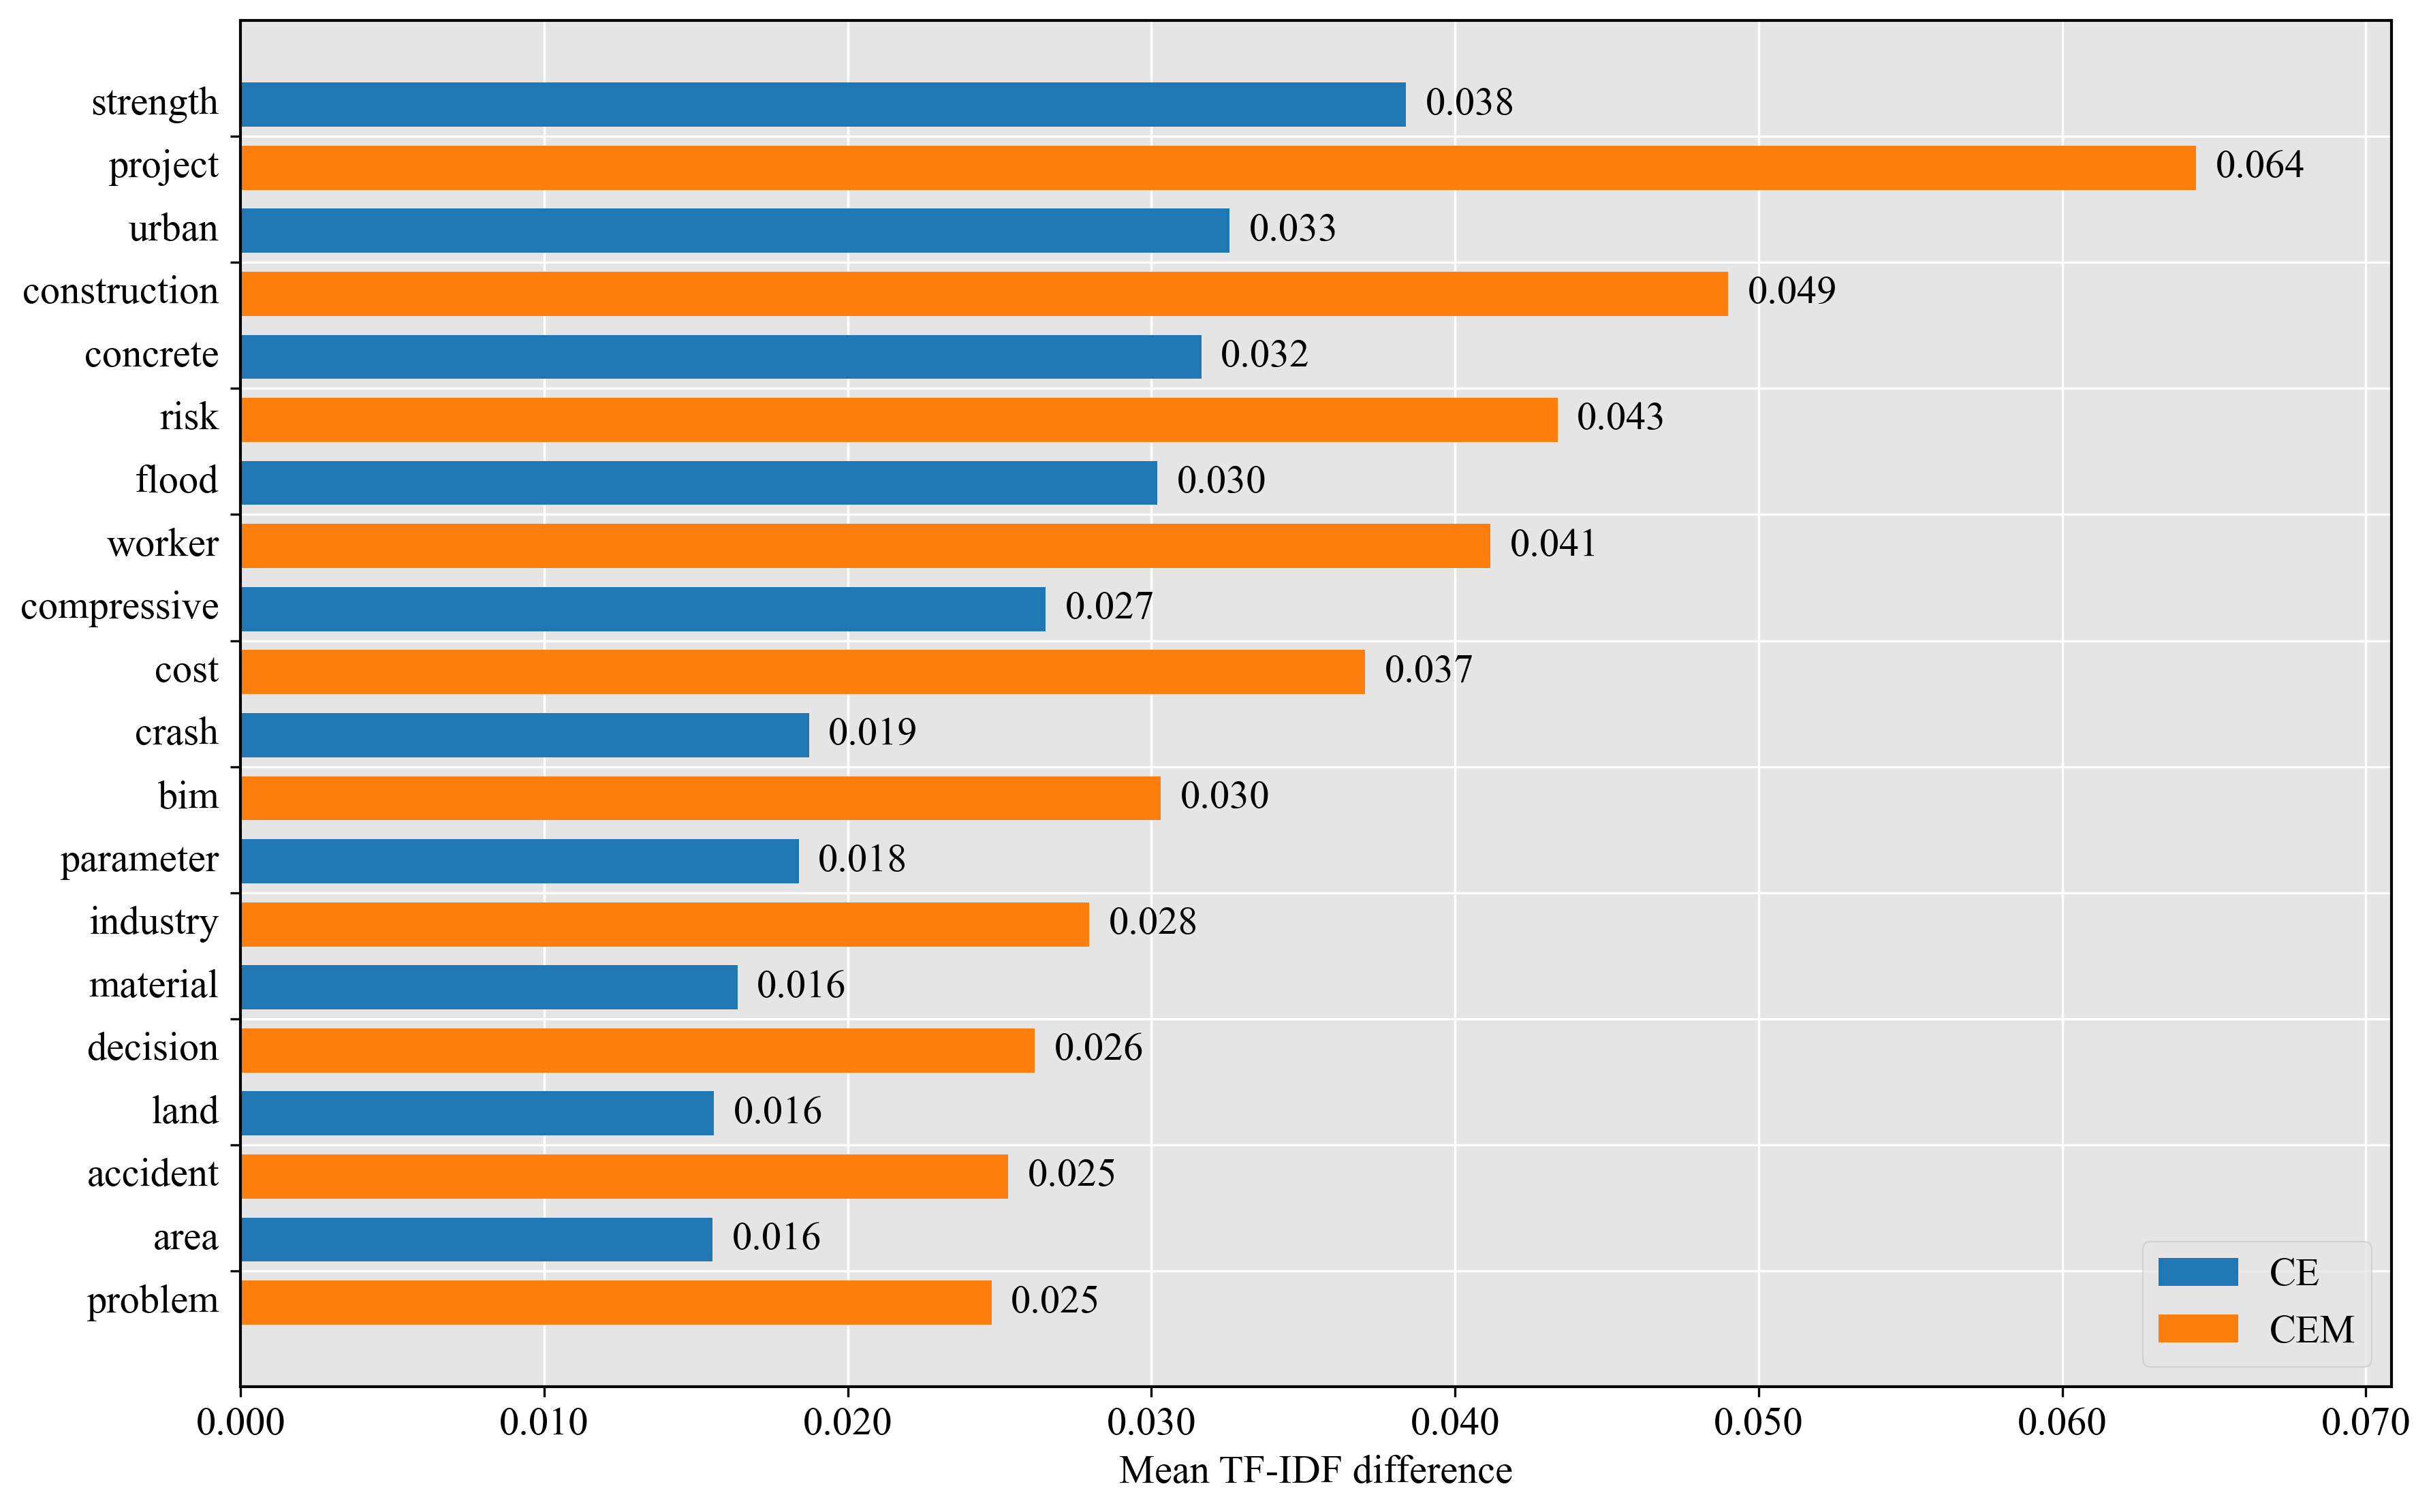

In [9]:
# === CE vs CEM — TF-IDF Distinctive Terms from Abstracts (lemmatized; Times New Roman) ===
# Requirements: pandas, scikit-learn, matplotlib, nltk
# If needed: pip install scikit-learn nltk matplotlib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

# --- Use ggplot style base ---
plt.style.use("ggplot")

# --- Global font / color style (as in your journal plot) ---
mpl.rcParams["font.family"]     = "Times New Roman"
mpl.rcParams["text.color"]      = "black"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"]  = "black"
mpl.rcParams["axes.titlecolor"] = "black"
mpl.rcParams["xtick.color"]     = "black"
mpl.rcParams["ytick.color"]     = "black"

# --- NLTK stopwords + lemmatizer (download once if missing) ---
try:
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag
except Exception:
    import nltk
    nltk.download("stopwords")
    nltk.download("wordnet")
    nltk.download("omw-1.4")
    try:
        nltk.download("averaged_perceptron_tagger")
    except Exception:
        pass
    from nltk.corpus import stopwords, wordnet
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

# -------------------- CONFIG --------------------
CSV_PATH      = "xai_references_labeled.csv"
FIELD_COL     = "field"
ABSTRACT_COL  = "abstract"

TOP_K         = 20          # compute this many distinctive terms
NGRAM_RANGE   = (1, 2)
MIN_DF        = 2
MAX_FEATURES  = 20000

# how many ranks to show in the final figure (Rank 1..K)
RANK_K        = 10          # set to TOP_K if you want all of them

# Uppercase whitelist so we keep short technical tokens (kept in lowercase after cleaning)
DOMAIN_WHITELIST = {"bim", "ohs", "fem", "gnn", "cnn", "svm", "lstm", "gru"}

STOPWORDS_EN = set(stopwords.words("english"))

CUSTOM_STOPWORDS = {
    "the", "and", "for", "this", "with", "that", "are", "was", "were", "from", "all",
    "can", "these", "which", "between", "into", "their", "most", "high",
    "elsevier", "rights", "reserved",
    "study", "analysis", "research", "results", "framework", "approach", "methods",
    "method", "proposed", "using", "used", "based", "data", "dataset", "models", "model",
    "performance", "accuracy", "variables", "features", "factors", "findings", "paper", "work",
    "machine", "learning", "explainable", "interpretable", "additive", "shap", "shapley",
    "xgboost", "artificial", "intelligence", "ai", "deep", "neural", "network", "networks",
    "algorithm", "algorithms", "prediction", "predictive",
    "significant", "different", "however", "time", "making", "important", "key", "existing",
    "include", "including", "across", "due", "best", "among", "critical", "new", "values",
    "enhance", "improve", "also", "well", "provide", "provides", "compared", "level", "levels",
    "process", "processes", "development", "developed", "insights", "accurate", "optimal",
    "support", "understanding", "inf"
}
STOPWORDS_ALL = STOPWORDS_EN | CUSTOM_STOPWORDS

# -------------------- HELPERS --------------------
def basic_clean(text: str) -> str:
    """Lowercase and keep letters/spaces only."""
    if pd.isna(text):
        return ""
    text = re.sub(r"[^a-zA-Z\s]", " ", str(text).lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Map NLTK POS tag to WordNet POS for better lemmatization
def _wn_pos(tag: str):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  # default to noun

_lemmatizer = WordNetLemmatizer()

def _lemmatize_tokens(tokens):
    """Lemmatize with POS tags if tagger is available; otherwise noun-default."""
    try:
        tagged = pos_tag(tokens)
        return [_lemmatizer.lemmatize(tok, _wn_pos(pos)) for tok, pos in tagged]
    except Exception:
        return [_lemmatizer.lemmatize(tok) for tok in tokens]

def analyzer_fn(doc: str):
    """
    Custom analyzer:
    clean → tokenize → stopword filter → lemmatize → filter short tokens
    unless whitelisted.
    """
    doc = basic_clean(doc)
    if not doc:
        return []
    toks = [t for t in doc.split() if t not in STOPWORDS_ALL]
    if not toks:
        return []
    toks = _lemmatize_tokens(toks)
    kept = []
    for t in toks:
        if len(t) <= 3 and t not in DOMAIN_WHITELIST:
            continue
        kept.append(t)
    return kept

def top_distinctive_terms(tfidf, terms, y, target_label, other_label, topk=20):
    """Return DataFrame of top distinctive terms for target_label vs other_label."""
    target_mask = (y == target_label)
    other_mask  = (y == other_label)
    mean_target = tfidf[target_mask].mean(axis=0).A1
    mean_other  = tfidf[other_mask].mean(axis=0).A1
    diff = mean_target - mean_other
    order = np.argsort(-diff)[:topk]
    return pd.DataFrame({
        "term": terms[order],
        f"mean_{target_label}": mean_target[order],
        f"mean_{other_label}":  mean_other[order],
        "distinctiveness": diff[order]
    })

def pad_terms(vals, terms, k):
    """Pad values and term labels to length k."""
    vals = np.asarray(vals, dtype=float)
    terms = list(terms)
    if len(vals) < k:
        vals = np.pad(vals, (0, k - len(vals)), constant_values=0.0)
    else:
        vals = vals[:k]
    if len(terms) < k:
        terms = terms + [""] * (k - len(terms))
    else:
        terms = terms[:k]
    return vals, terms

# -------------------- LOAD --------------------
df = pd.read_csv(CSV_PATH)
df = df[[FIELD_COL, ABSTRACT_COL]].dropna(subset=[ABSTRACT_COL]).copy()
df[FIELD_COL] = df[FIELD_COL].astype(str).str.strip().str.upper()
df = df[df[FIELD_COL].isin(["CE", "CEM"])]

# -------------------- VECTORIZE (after normalization/lemmatization) --------------------
vectorizer = TfidfVectorizer(
    analyzer=analyzer_fn,
    ngram_range=NGRAM_RANGE,
    min_df=MIN_DF,
    max_features=MAX_FEATURES,
    lowercase=False,   # we already lowercased in basic_clean
    token_pattern=None # required when using custom analyzer
)
X = vectorizer.fit_transform(df[ABSTRACT_COL])
terms = np.array(vectorizer.get_feature_names_out())
y = df[FIELD_COL].to_numpy()

# -------------------- DISTINCTIVE TERMS --------------------
ce_vs_cem = top_distinctive_terms(X, terms, y, "CE",  "CEM", topk=TOP_K)
cem_vs_ce = top_distinctive_terms(X, terms, y, "CEM", "CE",  topk=TOP_K)

# -------------------- PRINT RESULTS (optional) --------------------
pd.set_option("display.max_colwidth", 60)
print("\nTop distinctive terms for CE (vs CEM) — TF-IDF mean difference")
print(ce_vs_cem.to_string(index=False))
print("\nTop distinctive terms for CEM (vs CE) — TF-IDF mean difference")
print(cem_vs_ce.to_string(index=False))

# -------------------- PLOT (grouped terms, CE vs CEM) --------------------
# -------------------- CLEAN PLOT (final polished version) --------------------

# Take top RANK_K
ce_vals_raw  = ce_vs_cem["distinctiveness"].values
ce_terms_raw = ce_vs_cem["term"].values
cem_vals_raw = cem_vs_ce["distinctiveness"].values
cem_terms_raw= cem_vs_ce["term"].values

ce_vals,  ce_terms  = pad_terms(ce_vals_raw,  ce_terms_raw,  RANK_K)
cem_vals, cem_terms = pad_terms(cem_vals_raw, cem_terms_raw, RANK_K)

# Y positions
y_pos = np.arange(RANK_K)

# Adjust spacing
bar_height = 0.35
pair_gap   = 0.15   # vertical gap between CE–CEM pairs

fig, ax = plt.subplots(figsize=(12, 0.6 * RANK_K + 1.5), dpi=300)

# Plot CE and CEM bars
ax.barh(y_pos - bar_height/2 - pair_gap/2, ce_vals,  height=bar_height,
        color="#1f77b4", label="CE")
ax.barh(y_pos + bar_height/2 + pair_gap/2, cem_vals, height=bar_height,
        color="#ff7f0e", label="CEM")

# Remove existing Y-tick labels
ax.set_yticks(y_pos)
ax.set_yticklabels([""] * RANK_K)

# Invert so top is Rank 1
ax.invert_yaxis()

# Axis label
ax.set_xlabel("Mean TF-IDF difference", fontsize=14)

# Style ticks
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# Adjust x-limit (fix empty right space)
xmax = max(ce_vals.max(), cem_vals.max())
ax.set_xlim(0, xmax * 1.1)

# --- LEFT SIDE LABELS (term names only) ---
for yy, ce_t, cem_t in zip(y_pos, ce_terms, cem_terms):
    if ce_t:
        ax.text(-0.01, yy - (bar_height/2 + pair_gap/2), ce_t,
                va="center", ha="right", fontsize=14,
                transform=ax.get_yaxis_transform())

    if cem_t:
        ax.text(-0.01, yy + (bar_height/2 + pair_gap/2), cem_t,
                va="center", ha="right", fontsize=14,
                transform=ax.get_yaxis_transform())

# --- RIGHT SIDE LABELS (values only) ---
offset = xmax * 0.01
for yy, ce_v, cem_v in zip(y_pos, ce_vals, cem_vals):

    if ce_v > 0:
        ax.text(ce_v + offset,
                yy - (bar_height/2 + pair_gap/2),
                f"{ce_v:.3f}",
                va="center", ha="left", fontsize=14)

    if cem_v > 0:
        ax.text(cem_v + offset,
                yy + (bar_height/2 + pair_gap/2),
                f"{cem_v:.3f}",
                va="center", ha="left", fontsize=14)

# Legend
ax.legend(loc="lower right", fontsize=14)

plt.tight_layout()
plt.show()



=== CE Topics (LDA) ===

Topic 1:
  • 0.999 — Performance-based seismic design of Ultra-High-Performance Concrete (UHPC) bridge columns with design example 
  • 0.998 — Forecasting the strength of nanocomposite concrete containing carbon nanotubes by interpretable machine learni
  • 0.998 — Forecasting the strength of preplaced aggregate concrete using interpretable machine learning approaches
  • 0.998 — Data-driven models for predicting compressive strength of 3D-printed fiber-reinforced concrete using interpret
  • 0.998 — An explainable machine learning (XML) approach to determine strength of glass powder concrete

Topic 2:
  • 0.998 — Investigating the impact of borehole field data's input parameters on the forecasting accuracy of multivariate
  • 0.998 — Predicting pull-out strength and failure modes of metal anchors embedded in masonry structures using explainab
  • 0.998 — Interpretable machine learning models for predicting probabilistic axial buckling strength of steel circu

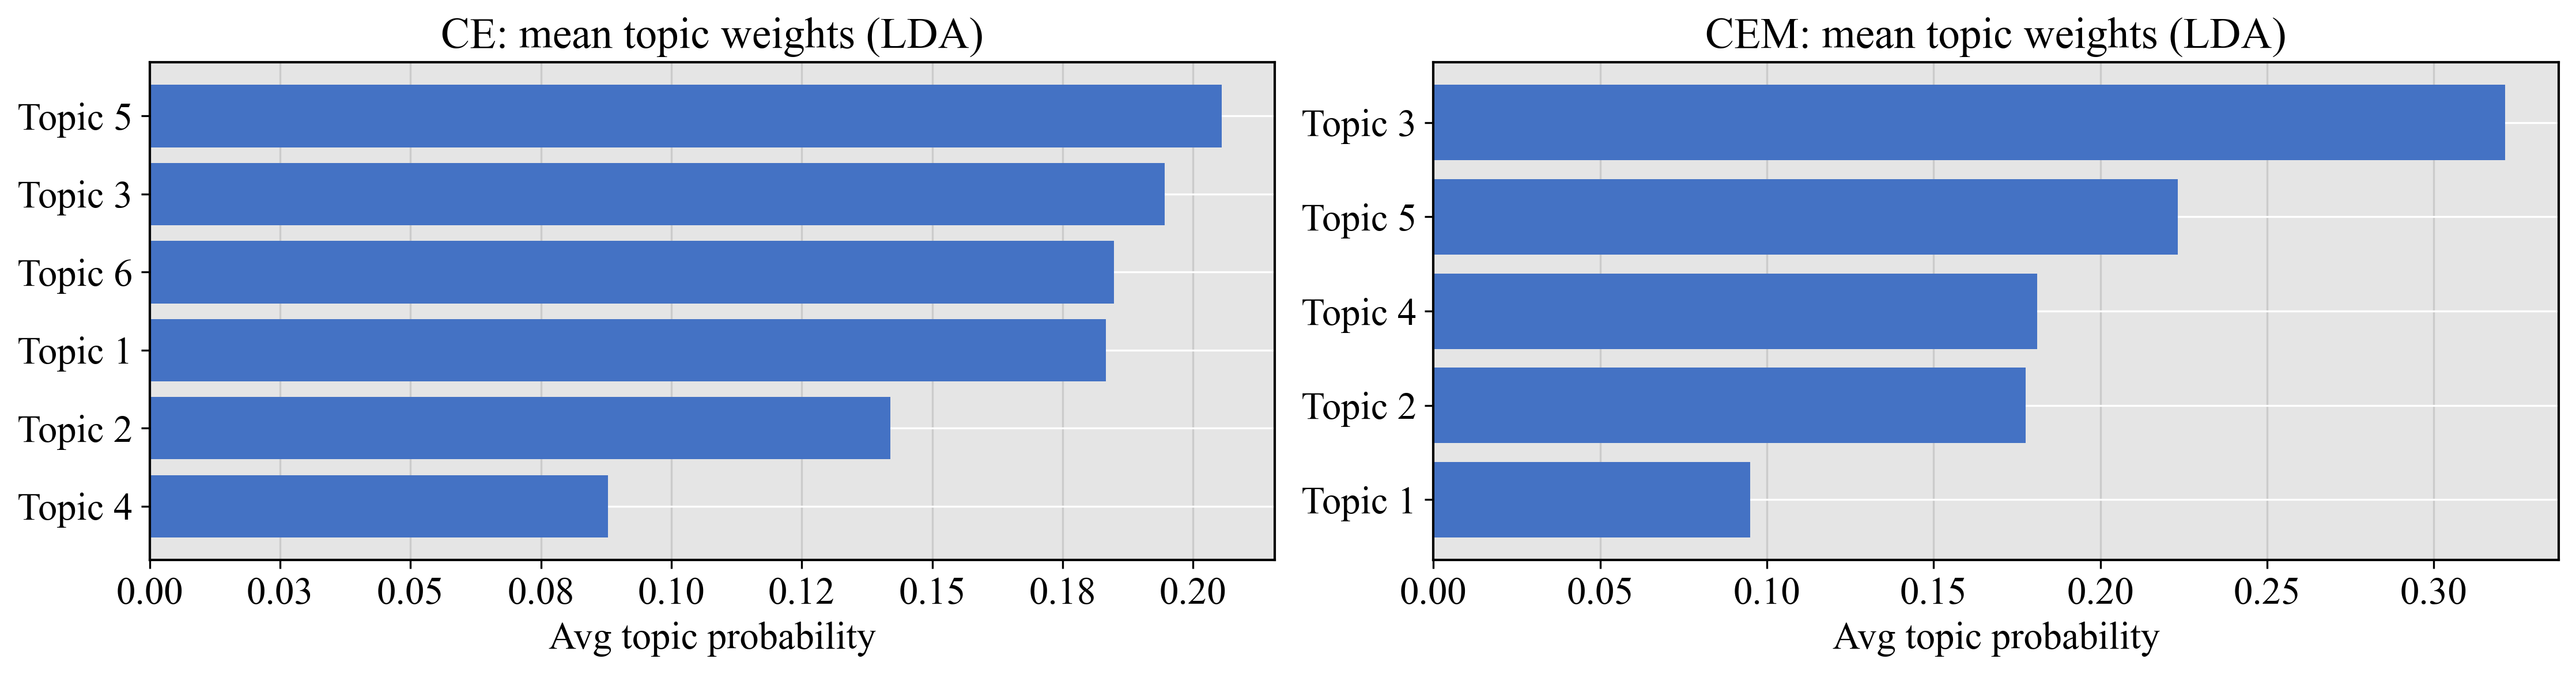

In [5]:
# === LDA Topic Modeling for CE and CEM abstracts (ggplot-styled, twin subplots) ===
# If gensim isn't installed:  pip install gensim

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from collections import Counter

# ---------- visual style (match TF-IDF figure) ----------
plt.style.use("ggplot")
plt.rcParams.update({
    "font.family": "Times New Roman",
    "text.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black"
})

# ---------- stopwords (as before) ----------
try:
    from nltk.corpus import stopwords
except Exception:
    import nltk
    nltk.download("stopwords")
    from nltk.corpus import stopwords

STOP_EN = set(stopwords.words("english"))
CUSTOM = {
    "the","and","for","this","with","that","are","was","were","from","all",
    "can","these","which","between","into","their","most","high",
    "elsevier","rights","reserved",
    "study","analysis","research","results","framework","approach","methods","method",
    "proposed","using","used","based","data","dataset","models","model",
    "performance","accuracy","variables","features","factors","findings","paper","work",
    "machine","learning","explainable","interpretable","additive","shap","shapley","xgboost",
    "artificial","intelligence","ai","deep","neural","network","networks","algorithm","algorithms",
    "prediction","predictive",
    "significant","different","however","time","making","important","key","existing","include",
    "including","across","due","best","among","critical","new","values","enhance","improve","also",
    "well","provide","provides","compared","level","levels","process","processes","development",
    "developed","insights","accurate","optimal","support","understanding","inf"
}
STOP_ALL = STOP_EN | CUSTOM

def tokenize_clean(s: str):
    if pd.isna(s): return []
    s = re.sub(r"[^a-zA-Z\s]", " ", str(s).lower())
    s = re.sub(r"\s+", " ", s).strip()
    toks = [t for t in s.split() if len(t) > 2 and t not in STOP_ALL]
    return toks

# ---------- load ----------
CSV = "xai_references_labeled.csv"
df = pd.read_csv(CSV)
df = df[df["field"].isin(["CE","CEM"])].dropna(subset=["abstract"]).copy()
df["tokens"] = df["abstract"].apply(tokenize_clean)

# ---------- gensim ----------
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

def lda_fit_and_summarize(sub_df: pd.DataFrame, num_topics=6,
                          no_below=3, no_above=0.6, passes=15,
                          random_state=42, topn=12):
    """
    Train LDA on one field and return:
      - topic_means: mean topic probability across documents (length num_topics)
      - topic_top_terms: list of strings for printing/reporting
    Also prints top representative papers per topic (up to 5).
    """
    texts  = sub_df["tokens"].tolist()
    titles = sub_df.get("title", pd.Series([""]*len(sub_df))).fillna("").tolist()

    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=20000)
    corpus = [dictionary.doc2bow(t) for t in texts]

    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=random_state,
        passes=passes,
        alpha="auto",
        eta="auto",
        eval_every=None
    )

    # topic labels
    topic_top_terms = []
    for k in range(num_topics):
        terms = [w for w, _ in lda.show_topic(k, topn=topn)]
        topic_top_terms.append(f"Topic {k+1}: {', '.join(terms)}")

    # doc-topic distributions
    doc_topics = [sorted(lda.get_document_topics(bow), key=lambda x: -x[1]) for bow in corpus]
    dom_topic  = np.array([dt[0][0] if dt else -1 for dt in doc_topics])
    dom_weight = np.array([dt[0][1] if dt else 0.0 for dt in doc_topics])

    # top papers per topic (printed)
    for k in range(num_topics):
        idx = np.where(dom_topic == k)[0]
        if len(idx) == 0:
            print(f"\nTopic {k+1}: (no dominant documents)")
            continue
        order = idx[np.argsort(-dom_weight[idx])][:5]
        print(f"\nTopic {k+1}:")
        for i in order:
            print(f"  • {dom_weight[i]:.3f} — {titles[i][:110]}")

    # mean topic probabilities
    topic_means = np.zeros(num_topics)
    for probs in doc_topics:
        for k, p in probs:
            topic_means[k] += p
    topic_means /= max(len(doc_topics), 1)

    return topic_means, topic_top_terms

# ---------- configs (as before) ----------
CONFIG = {
    "CE":  {"num_topics": 6, "no_below": 3, "no_above": 0.6, "passes": 20},
    "CEM": {"num_topics": 5, "no_below": 2, "no_above": 0.7, "passes": 25},
}

# ---------- fit per field & collect ----------
topic_means_dict = {}
topic_labels_dict = {}

for field in ["CE", "CEM"]:
    print(f"\n=== {field} Topics (LDA) ===")
    sub = df[df["field"] == field].reset_index(drop=True)
    means, labels = lda_fit_and_summarize(
        sub_df=sub,
        num_topics=CONFIG[field]["num_topics"],
        no_below=CONFIG[field]["no_below"],
        no_above=CONFIG[field]["no_above"],
        passes=CONFIG[field]["passes"],
        random_state=42,
        topn=12
    )
    topic_means_dict[field] = means
    topic_labels_dict[field] = labels
    # Also print topic term strings
    for line in labels:
        print(line)

# ---------- plotting: side-by-side barh with TF-IDF styling ----------
def plot_topic_strength(ax, means, field_title):
    order = np.argsort(-means)
    ax.barh([f"Topic {i+1}" for i in order[::-1]], means[order][::-1], color="#4472C4")
    ax.set_title(f"{field_title}: mean topic weights (LDA)", fontsize=18)
    ax.set_xlabel("Avg topic probability", fontsize=16)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(axis="x", alpha=0.25, color="gray")
    ax.tick_params(axis='x', labelsize=16, colors="black")
    ax.tick_params(axis='y', labelsize=16, colors="black")

    # enforce Times New Roman on tick labels
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontname("Times New Roman")
        lbl.set_color("black")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), dpi=300)
plot_topic_strength(ax1, topic_means_dict["CE"],  "CE")
plot_topic_strength(ax2, topic_means_dict["CEM"], "CEM")
plt.tight_layout()
# plt.savefig("lda_topic_strength_CE_vs_CEM.tif", dpi=300, bbox_inches="tight")
plt.show()



=== CE Topics (LDA) ===

Topic 1:
  • 0.999 — Performance-based seismic design of Ultra-High-Performance Concrete (UHPC) bridge columns with design example 
  • 0.998 — Forecasting the strength of nanocomposite concrete containing carbon nanotubes by interpretable machine learni
  • 0.998 — Forecasting the strength of preplaced aggregate concrete using interpretable machine learning approaches
  • 0.998 — Data-driven models for predicting compressive strength of 3D-printed fiber-reinforced concrete using interpret
  • 0.998 — An explainable machine learning (XML) approach to determine strength of glass powder concrete

Topic 2:
  • 0.998 — Investigating the impact of borehole field data's input parameters on the forecasting accuracy of multivariate
  • 0.998 — Predicting pull-out strength and failure modes of metal anchors embedded in masonry structures using explainab
  • 0.998 — Interpretable machine learning models for predicting probabilistic axial buckling strength of steel circu

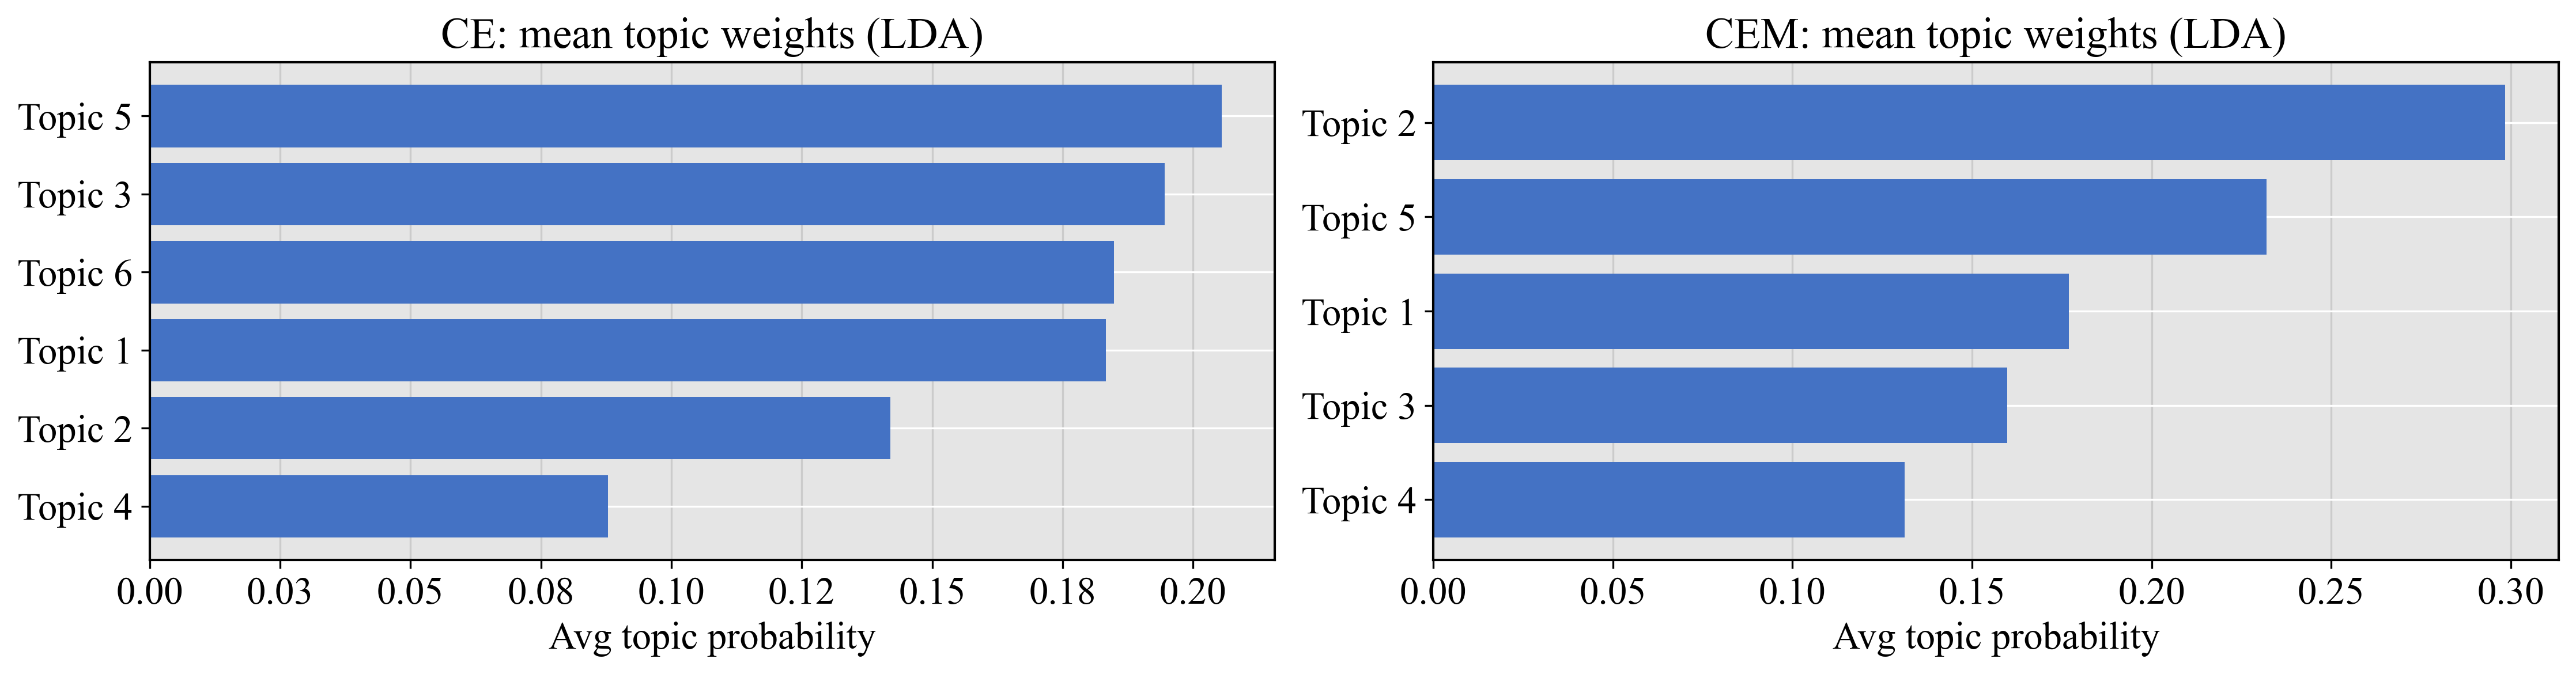

In [1]:
# === LDA Topic Modeling for CE and CEM abstracts (ggplot-styled, twin subplots) ===
# If gensim isn't installed:  pip install gensim

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from collections import Counter

# ---------- visual style (match TF-IDF figure) ----------
plt.style.use("ggplot")
plt.rcParams.update({
    "font.family": "Times New Roman",
    "text.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black"
})

# ---------- stopwords (as before) ----------
try:
    from nltk.corpus import stopwords
except Exception:
    import nltk
    nltk.download("stopwords")
    from nltk.corpus import stopwords

STOP_EN = set(stopwords.words("english"))
CUSTOM = {
    "the","and","for","this","with","that","are","was","were","from","all",
    "can","these","which","between","into","their","most","high",
    "elsevier","rights","reserved",
    "study","analysis","research","results","framework","approach","methods","method",
    "proposed","using","used","based","data","dataset","models","model",
    "performance","accuracy","variables","features","factors","findings","paper","work",
    "machine","learning","explainable","interpretable","additive","shap","shapley","xgboost",
    "artificial","intelligence","ai","deep","neural","network","networks","algorithm","algorithms",
    "prediction","predictive",
    "significant","different","however","time","making","important","key","existing","include",
    "including","across","due","best","among","critical","new","values","enhance","improve","also",
    "well","provide","provides","compared","level","levels","process","processes","development",
    "developed","insights","accurate","optimal","support","understanding","inf"
}
STOP_ALL = STOP_EN | CUSTOM

def tokenize_clean(s: str):
    if pd.isna(s): return []
    s = re.sub(r"[^a-zA-Z\s]", " ", str(s).lower())
    s = re.sub(r"\s+", " ", s).strip()
    toks = [t for t in s.split() if len(t) > 2 and t not in STOP_ALL]
    return toks

# ---------- load ----------
CSV = "xai_references_labeled.csv"
df = pd.read_csv(CSV)
df = df[df["field"].isin(["CE","CEM"])].dropna(subset=["abstract"]).copy()
df["tokens"] = df["abstract"].apply(tokenize_clean)

# ---------- gensim ----------
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

def lda_fit_and_summarize(sub_df: pd.DataFrame, num_topics=6,
                          no_below=3, no_above=0.6, passes=15,
                          random_state=42, topn=12):
    """
    Train LDA on one field and return:
      - topic_means: mean topic probability across documents (length num_topics)
      - topic_top_terms: list of strings for printing/reporting
    Also prints top representative papers per topic (up to 5).
    """
    texts  = sub_df["tokens"].tolist()
    titles = sub_df.get("title", pd.Series([""]*len(sub_df))).fillna("").tolist()

    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=20000)
    corpus = [dictionary.doc2bow(t) for t in texts]

    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=random_state,
        passes=passes,
        alpha="auto",
        eta="auto",
        eval_every=None
    )

    # topic labels
    topic_top_terms = []
    for k in range(num_topics):
        terms = [w for w, _ in lda.show_topic(k, topn=topn)]
        topic_top_terms.append(f"Topic {k+1}: {', '.join(terms)}")

    # doc-topic distributions
    doc_topics = [sorted(lda.get_document_topics(bow), key=lambda x: -x[1]) for bow in corpus]
    dom_topic  = np.array([dt[0][0] if dt else -1 for dt in doc_topics])
    dom_weight = np.array([dt[0][1] if dt else 0.0 for dt in doc_topics])

    # top papers per topic (printed)
    for k in range(num_topics):
        idx = np.where(dom_topic == k)[0]
        if len(idx) == 0:
            print(f"\nTopic {k+1}: (no dominant documents)")
            continue
        order = idx[np.argsort(-dom_weight[idx])][:5]
        print(f"\nTopic {k+1}:")
        for i in order:
            print(f"  • {dom_weight[i]:.3f} — {titles[i][:110]}")

    # mean topic probabilities
    topic_means = np.zeros(num_topics)
    for probs in doc_topics:
        for k, p in probs:
            topic_means[k] += p
    topic_means /= max(len(doc_topics), 1)

    return topic_means, topic_top_terms

# ---------- configs (as before) ----------
CONFIG = {
    "CE":  {"num_topics": 6, "no_below": 3, "no_above": 0.6, "passes": 20},
    "CEM": {"num_topics": 5, "no_below": 2, "no_above": 0.7, "passes": 25},
}

# ---------- fit per field & collect ----------
topic_means_dict = {}
topic_labels_dict = {}

for field in ["CE", "CEM"]:
    print(f"\n=== {field} Topics (LDA) ===")
    sub = df[df["field"] == field].reset_index(drop=True)
    means, labels = lda_fit_and_summarize(
        sub_df=sub,
        num_topics=CONFIG[field]["num_topics"],
        no_below=CONFIG[field]["no_below"],
        no_above=CONFIG[field]["no_above"],
        passes=CONFIG[field]["passes"],
        random_state=42,
        topn=12
    )
    topic_means_dict[field] = means
    topic_labels_dict[field] = labels
    # Also print topic term strings
    for line in labels:
        print(line)

# ---------- plotting: side-by-side barh with TF-IDF styling ----------
def plot_topic_strength(ax, means, field_title):
    order = np.argsort(-means)
    ax.barh([f"Topic {i+1}" for i in order[::-1]], means[order][::-1], color="#4472C4")
    ax.set_title(f"{field_title}: mean topic weights (LDA)", fontsize=18)
    ax.set_xlabel("Avg topic probability", fontsize=16)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(axis="x", alpha=0.25, color="gray")
    ax.tick_params(axis='x', labelsize=16, colors="black")
    ax.tick_params(axis='y', labelsize=16, colors="black")

    # enforce Times New Roman on tick labels
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontname("Times New Roman")
        lbl.set_color("black")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), dpi=300)
plot_topic_strength(ax1, topic_means_dict["CE"],  "CE")
plot_topic_strength(ax2, topic_means_dict["CEM"], "CEM")
plt.tight_layout()
# plt.savefig("lda_topic_strength_CE_vs_CEM.tif", dpi=300, bbox_inches="tight")
plt.show()


In [2]:
# ============================================================
# Coherence sweep + stability analysis for CE and CEM (LDA)
# Assumes:
#   - df already loaded
#   - df["field"] in {"CE", "CEM"}
#   - df["tokens"] created with tokenize_clean (same as previous code)
# ============================================================

import numpy as np
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment

# ----- configuration (harmonized with your main LDA code) -----
FIELD_CFG = {
    "CE": {
        "no_below": 3,
        "no_above": 0.60,
        "passes": 20,
        "k_grid": [4, 6, 8],  # values you report in the paper
        "k_final": 6          # chosen model in main code
    },
    "CEM": {
        "no_below": 2,
        "no_above": 0.70,
        "passes": 25,
        "k_grid": [4, 5, 7],
        "k_final": 5
    }
}

def build_corpus(sub_df, no_below, no_above):
    """Create texts, dictionary, and corpus for a subset (CE or CEM)."""
    texts = sub_df["tokens"].tolist()
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=20000)
    corpus = [dictionary.doc2bow(t) for t in texts]
    return texts, dictionary, corpus

def train_lda(corpus, dictionary, num_topics, passes, random_state):
    """Train a single LDA model with standard settings."""
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=random_state,
        passes=passes,
        alpha="auto",
        eta="auto",
        eval_every=None
    )
    return lda

def topic_term_matrix(lda, vocab_size):
    """
    Build a topic-term probability matrix of shape (num_topics, vocab_size).
    This is used for cosine similarity in the stability analysis.
    """
    num_topics = lda.num_topics
    mat = np.zeros((num_topics, vocab_size), dtype=float)
    for k in range(num_topics):
        for term_id, prob in lda.get_topic_terms(k, topn=vocab_size):
            mat[k, term_id] = prob
    return mat

# -------------------------------------------------------------
# 1) Coherence sweep (Cv) over different k values
# -------------------------------------------------------------
coherence_results = []

for field, cfg in FIELD_CFG.items():
    print(f"\n=== Coherence sweep for {field} ===")
    sub = df[df["field"] == field].reset_index(drop=True)

    texts, dictionary, corpus = build_corpus(
        sub_df=sub,
        no_below=cfg["no_below"],
        no_above=cfg["no_above"]
    )

    for k in cfg["k_grid"]:
        lda = train_lda(
            corpus=corpus,
            dictionary=dictionary,
            num_topics=k,
            passes=cfg["passes"],
            random_state=0
        )
        cm = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        )
        cv_score = cm.get_coherence()
        coherence_results.append({"field": field, "k": k, "cv": cv_score})
        print(f"{field}: k={k} → Cv={cv_score:.3f}")

# Optional: nice tabular view
coherence_df = pd.DataFrame(coherence_results)
print("\nCoherence summary:")
print(coherence_df.pivot(index="k", columns="field", values="cv"))

# -------------------------------------------------------------
# 2) Stability / sensitivity analysis over random seeds
#    (Hungarian-matched cosine similarity of topic-term dists)
# -------------------------------------------------------------
stability_results = []

for field, cfg in FIELD_CFG.items():
    print(f"\n=== Stability analysis for {field} (k={cfg['k_final']}) ===")
    sub = df[df["field"] == field].reset_index(drop=True)

    texts, dictionary, corpus = build_corpus(
        sub_df=sub,
        no_below=cfg["no_below"],
        no_above=cfg["no_above"]
    )

    vocab_size = len(dictionary)

    # Reference model (seed 0)
    ref_lda = train_lda(
        corpus=corpus,
        dictionary=dictionary,
        num_topics=cfg["k_final"],
        passes=cfg["passes"],
        random_state=0
    )
    ref_mat = topic_term_matrix(ref_lda, vocab_size)

    seed_sims = []

    # Seeds 1..10 (you can change range if needed)
    for seed in range(1, 11):
        lda_run = train_lda(
            corpus=corpus,
            dictionary=dictionary,
            num_topics=cfg["k_final"],
            passes=cfg["passes"],
            random_state=seed
        )
        run_mat = topic_term_matrix(lda_run, vocab_size)

        # Cosine similarity between reference topics and this run's topics
        sim_matrix = cosine_similarity(ref_mat, run_mat)

        # Hungarian matching to align topics (maximize similarity)
        row_ind, col_ind = linear_sum_assignment(-sim_matrix)
        aligned_sims = sim_matrix[row_ind, col_ind]

        seed_mean = aligned_sims.mean()
        seed_sims.append(seed_mean)
        print(f"  Seed {seed:2d}: mean aligned topic similarity = {seed_mean:.3f}")

    overall_mean = float(np.mean(seed_sims))
    overall_min  = float(np.min(seed_sims))
    overall_max  = float(np.max(seed_sims))

    stability_results.append({
        "field": field,
        "k_final": cfg["k_final"],
        "mean_similarity": overall_mean,
        "min_similarity": overall_min,
        "max_similarity": overall_max
    })

    print(
        f">>> {field} stability summary (k={cfg['k_final']}): "
        f"mean={overall_mean:.3f}, min={overall_min:.3f}, max={overall_max:.3f}"
    )

stability_df = pd.DataFrame(stability_results)
print("\nStability summary:")
print(stability_df)



=== Coherence sweep for CE ===
CE: k=4 → Cv=0.423
CE: k=6 → Cv=0.396
CE: k=8 → Cv=0.391

=== Coherence sweep for CEM ===
CEM: k=4 → Cv=0.320
CEM: k=5 → Cv=0.342
CEM: k=7 → Cv=0.359

Coherence summary:
field        CE       CEM
k                        
4      0.423358  0.320105
5           NaN  0.341550
6      0.396029       NaN
7           NaN  0.359465
8      0.390615       NaN

=== Stability analysis for CE (k=6) ===
  Seed  1: mean aligned topic similarity = 0.699
  Seed  2: mean aligned topic similarity = 0.694
  Seed  3: mean aligned topic similarity = 0.670
  Seed  4: mean aligned topic similarity = 0.717
  Seed  5: mean aligned topic similarity = 0.665
  Seed  6: mean aligned topic similarity = 0.664
  Seed  7: mean aligned topic similarity = 0.621
  Seed  8: mean aligned topic similarity = 0.741
  Seed  9: mean aligned topic similarity = 0.687
  Seed 10: mean aligned topic similarity = 0.671
>>> CE stability summary (k=6): mean=0.683, min=0.621, max=0.741

=== Stability analy

Total CE journal entries: 253
Total CEM journal entries: 55

All CE journals (frequency & percentage of CE):



All CEM journals (frequency & percentage of CEM):


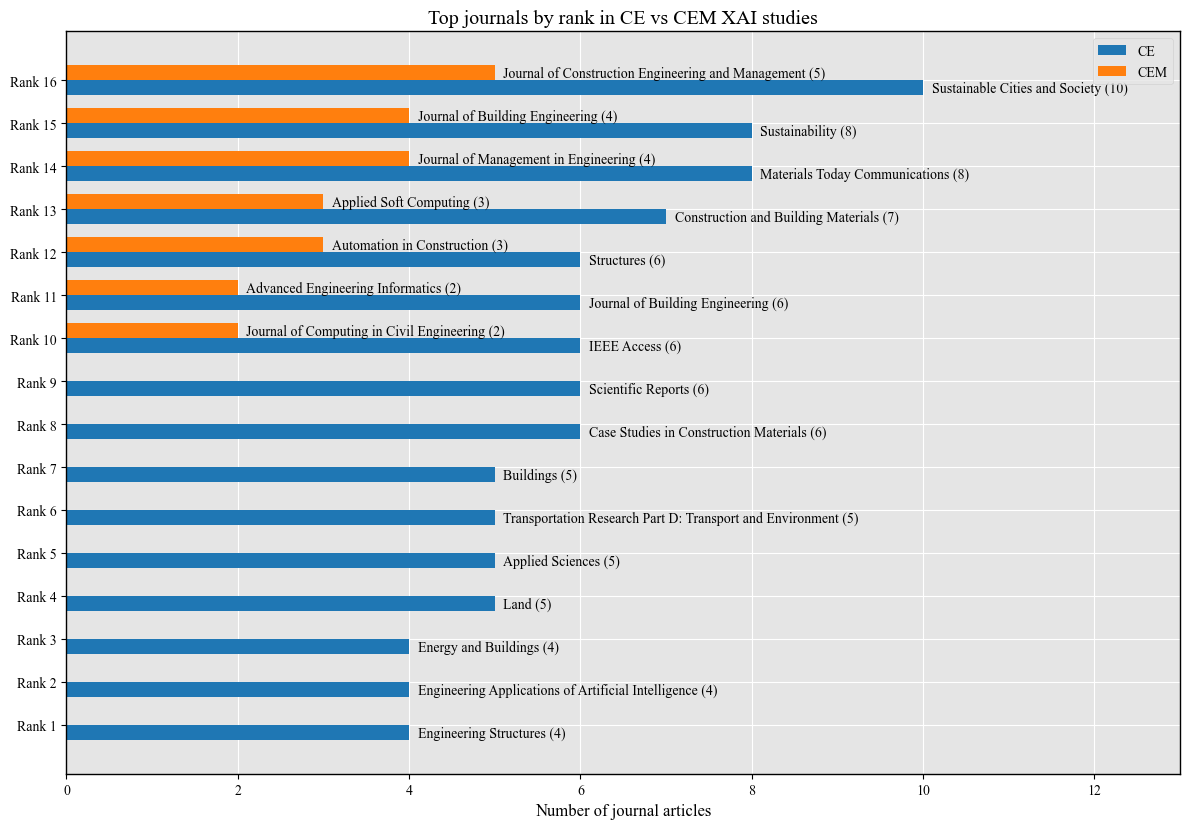

In [2]:
# ============================================================
# Combined CE & CEM top journals by rank
# One figure, 2 bars per rank (CE vs CEM), journal names can differ
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

CSV_PATH = "xai_references_labeled.csv"

# -----------------------
# Style
# -----------------------
plt.style.use("ggplot")
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["text.color"] = "black"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["axes.titlecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"

# -----------------------
# Load data
# -----------------------
df = pd.read_csv(CSV_PATH, dtype=str, keep_default_na=False)
df["journal"] = (
    df["journal"]
    .astype(str)
    .str.strip()
    .replace({"": np.nan, "none": np.nan, "None": np.nan, "NaN": np.nan})
)

# -----------------------
# Journal counts by field
# -----------------------
ce_journals = (
    df[df["field"].str.lower().eq("ce")]["journal"]
    .dropna()
)
cem_journals = (
    df[df["field"].str.lower().eq("cem")]["journal"]
    .dropna()
)

ce_counts = ce_journals.value_counts()
cem_counts = cem_journals.value_counts()

total_ce = int(ce_counts.sum())
total_cem = int(cem_counts.sum())

print(f"Total CE journal entries: {total_ce}")
print(f"Total CEM journal entries: {total_cem}")

# -----------------------
# Full reference tables (optional, for checking)
# -----------------------
ce_table = (
    ce_counts.rename("frequency")
    .to_frame()
    .reset_index()
    .rename(columns={"index": "journal"})
)
ce_table["percentage"] = (ce_table["frequency"] / total_ce) * 100
ce_table = ce_table.sort_values(["frequency", "journal"], ascending=[False, True], ignore_index=True)

cem_table = (
    cem_counts.rename("frequency")
    .to_frame()
    .reset_index()
    .rename(columns={"index": "journal"})
)
cem_table["percentage"] = (cem_table["frequency"] / total_cem) * 100
cem_table = cem_table.sort_values(["frequency", "journal"], ascending=[False, True], ignore_index=True)

print("\nAll CE journals (frequency & percentage of CE):")
display(ce_table.style.format({"percentage": "{:.2f}%"}))

print("\nAll CEM journals (frequency & percentage of CEM):")
display(cem_table.style.format({"percentage": "{:.2f}%"}))

# -----------------------
# Apply your thresholds (adjust if needed)
#   - CE: > 3 papers
#   - CEM: > 1 paper
# -----------------------
ce_top = ce_counts[ce_counts > 3]
cem_top = cem_counts[cem_counts > 1]

if ce_top.empty:
    raise ValueError("No CE journals with more than 3 papers found.")
if cem_top.empty:
    raise ValueError("No CEM journals with more than 1 paper found.")

# Sort each field by frequency (descending, then alphabetically for ties)
ce_top = ce_top.sort_values(ascending=False)
cem_top = cem_top.sort_values(ascending=False)

# -----------------------
# Build rank-based comparison
# Rank 1 = top CE vs top CEM, Rank 2 = second CE vs second CEM, etc.
# Journals can differ at each rank (this is intended)
# -----------------------
n_ce = len(ce_top)
n_cem = len(cem_top)
k = max(n_ce, n_cem)  # number of ranks to show

ranks = np.arange(1, k + 1)          # 1, 2, 3, ...
y = ranks[::-1]                      # reverse so Rank 1 at top

# Helper: get (journal, value) at a rank index, or blanks if missing
def get_rank(series, idx):
    if idx < len(series):
        return series.index[idx], series.values[idx]
    else:
        return "", 0

ce_labels = []
ce_values = []
cem_labels = []
cem_values = []

for i in range(k):
    j_ce, v_ce = get_rank(ce_top, i)
    j_cem, v_cem = get_rank(cem_top, i)
    ce_labels.append(j_ce)
    ce_values.append(v_ce)
    cem_labels.append(j_cem)
    cem_values.append(v_cem)

ce_values = np.array(ce_values, dtype=float)
cem_values = np.array(cem_values, dtype=float)

# -----------------------
# Plot: grouped horizontal bars by rank
# -----------------------
bar_height = 0.35

fig, ax = plt.subplots(figsize=(12, 0.4 * k + 2))

ax.barh(y - bar_height/2, ce_values, height=bar_height,
        color="#1f77b4", label="CE")
ax.barh(y + bar_height/2, cem_values, height=bar_height,
        color="#ff7f0e", label="CEM")

ax.set_yticks(y)
ax.set_yticklabels([f"Rank {r}" for r in ranks[::-1]])  # Rank 1 at top
ax.set_xlabel("Number of journal articles")
ax.set_title("Top journals by rank in CE vs CEM XAI studies")

# Extend x-limit a bit for labels
xmax = max(ce_values.max(), cem_values.max()) * 1.3
ax.set_xlim(0, xmax if xmax > 0 else 1)

# Add journal-name + count labels for each bar
for yy, ce_val, cem_val, ce_j, cem_j in zip(y, ce_values, cem_values, ce_labels, cem_labels):
    # CE bar label
    if ce_val > 0:
        ax.text(ce_val + 0.1, yy - bar_height/2,
                f"{ce_j} ({int(ce_val)})",
                va="center", ha="left", fontsize=10)
    # CEM bar label
    if cem_val > 0:
        ax.text(cem_val + 0.1, yy + bar_height/2,
                f"{cem_j} ({int(cem_val)})",
                va="center", ha="left", fontsize=10)

ax.legend(loc="best")
plt.tight_layout()
plt.show()


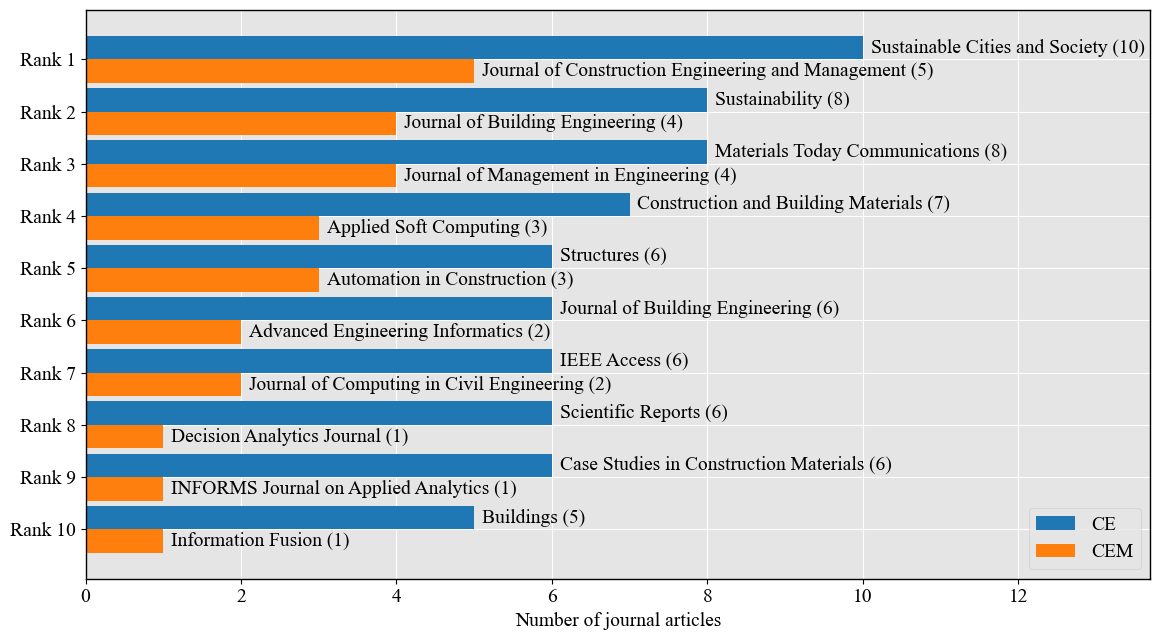

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

CSV_PATH = "xai_references_labeled.csv"

# -----------------------
# Style
# -----------------------
plt.style.use("ggplot")
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["text.color"] = "black"
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["axes.titlecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"

# -----------------------
# Load data
# -----------------------
df = pd.read_csv(CSV_PATH, dtype=str, keep_default_na=False)

def clean_journals(sub_df):
    journals = (
        sub_df["journal"]
        .astype(str)
        .str.strip()
        .replace({"": np.nan, "none": np.nan, "None": np.nan, "NaN": np.nan})
        .dropna()
    )
    counts = journals.value_counts()
    return counts

# Journal counts for each field
ce_counts  = clean_journals(df[df["field"].str.lower().eq("ce")])
cem_counts = clean_journals(df[df["field"].str.lower().eq("cem")])

# -----------------------
# Take TOP 10 for each
# -----------------------
ce_top  = ce_counts.head(10)
cem_top = cem_counts.head(10)

def pad_to_10(series):
    """Return labels and values for ranks 1–10 (pad with empty / 0 if needed)."""
    labels = []
    values = []
    for i in range(10):
        if i < len(series):
            labels.append(series.index[i])
            values.append(series.values[i])
        else:
            labels.append("")
            values.append(0)
    return labels, np.array(values, dtype=float)

ce_labels, ce_values   = pad_to_10(ce_top)
cem_labels, cem_values = pad_to_10(cem_top)

# -----------------------
# Build rank axis
# -----------------------
k = 10
y = np.arange(k)                  # 0..9
ranks = np.arange(1, k + 1)       # 1..10

# -----------------------
# Plot grouped horizontal bars
# -----------------------
bar_height = 0.45
fig, ax = plt.subplots(figsize=(12, 0.45 * k + 2))

ax.barh(y - bar_height/2, ce_values,  height=bar_height,
        color="#1f77b4", label="CE")
ax.barh(y + bar_height/2, cem_values, height=bar_height,
        color="#ff7f0e", label="CEM")

ax.set_yticks(y)
ax.set_yticklabels([f"Rank {r}" for r in ranks], fontsize=14)

# Rank 1 at top
ax.invert_yaxis()

ax.set_xlabel("Number of journal articles", fontsize=14)

# Increase tick font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Expand limits
xmax = max(ce_values.max(), cem_values.max()) * 1.37
ax.set_xlim(0, xmax if xmax > 0 else 1)

# Text labels: "Journal name (count)" on each bar
for yy, ce_val, cem_val, ce_j, cem_j in zip(y, ce_values, cem_values, ce_labels, cem_labels):
    if ce_val > 0:
        ax.text(ce_val + 0.1, yy - bar_height/2,
                f"{ce_j} ({int(ce_val)})",
                va="center", ha="left", fontsize=14)
    if cem_val > 0:
        ax.text(cem_val + 0.1, yy + bar_height/2,
                f"{cem_j} ({int(cem_val)})",
                va="center", ha="left", fontsize=14)

# Legend with larger font
ax.legend(loc="lower right", fontsize=14)

plt.tight_layout()
plt.show()
